## **Load Credential**

In [ ]:
!pip install python-dotenv

In [ ]:
from dotenv import load_dotenv
import os
from pathlib import Path

env_path = Path('../.env')
print(env_path)
load_dotenv(dotenv_path=env_path)

db_credential = os.getenv('MONGODB_CREDENTIALS')
if db_credential is None:
    raise ValueError("MONGODB_CREDENTIALS not found in .env file")

fred_key = os.getenv('FRED_API_KEY')
if fred_key is None:
    raise ValueError("FRED_API_KEY not found in .env file")

## **Library**

In [3]:
!pip install ta ccxt

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 130.7/130.7 kB 1.9 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.8/5.8 MB 58.1 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 626.2/626.2 kB 16.8 MB/s eta 0:00:00:00:01
  Created wheel for ta: filename=ta-0.11.0-py3-none-any.whl size=29412 sha256=5d981b6986a16213aaa97806a23cc4222ee984eda8a618d79d4247d16d58fc26
  Stored in directory: /root/.cache/pip/wheels/a1/d7/29/7781cc5eb9a3659d032d7d15bdd0f49d07d2b24fec29f44bc4
Successfully built ta


In [ ]:
import ccxt
import pandas as pd
import numpy as np
import pytz
from pymongo import MongoClient, ASCENDING
from pymongo.errors import DuplicateKeyError, BulkWriteError
from fredapi import Fred

from functools import reduce

import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torch.distributed as dist
import torch.multiprocessing as mp
from torch.nn.parallel import DistributedDataParallel as DDP
from torch.cuda.amp import autocast, GradScaler

from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import lightgbm as lgb

import ta

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
from plotly.subplots import make_subplots

import warnings
import os
import time
from datetime import datetime, timedelta
import optuna
from tqdm import tqdm
import pickle
import json

## **Data Collection** (don't run this cell, thanks)

In [ ]:
class CryptoDataExtractor:
    def __init__(self, exchange_id='kucoin', symbols=['SOL/USDT','BTC/USDT'], timeframe='1h', mongo_uri=None, db_name='crypto_data', fred_api_key='eec17c9421eb1c65597dc75bdbc60b67'):
        self.exchange_id = exchange_id
        self.symbols = symbols
        self.timeframe = timeframe
        self.mongo_uri = mongo_uri
        self.db_name = db_name
        self.mongo_client = None
        self.db = None
        self.fred_api_key = fred_api_key
        self.fred = None

        if fred_api_key:
            try:
                self.fred = Fred(api_key=fred_api_key)
                print("Connected to FRED API")
            except Exception as e:
                print(f"Error connecting to FRED API: {e}")
                warnings.warn("FRED API connection failed. Economic indicators will not be available.")

        try:
            exchange_class = getattr(ccxt, exchange_id)
            self.exchange = exchange_class({
                'enableRateLimit': True,
                'timeout': 30000,
                'adjustForTimeDifference': True,
            })
            print(f"Connected to {exchange_id} exchange")
        except Exception as e:
            print(f"Error connecting to exchange: {e}")
            raise

        if mongo_uri:
            try:
                self.mongo_client = MongoClient(mongo_uri)
                self.db = self.mongo_client[db_name]
                print(f"Connected to MongoDB database: {db_name}")

                collection_name = f"{self.symbols[0].replace('/', '_')}_{self.timeframe}"
                self.collection = self.db[collection_name]

                self.collection.create_index([("timestamp", ASCENDING)], unique=True)
                print(f"Created/verified index on timestamp for collection: {collection_name}")
            except Exception as e:
                print(f"Error connecting to MongoDB: {e}")
                raise

    def _fetch_ohlcv_for_symbol(self, symbol, limit=1000, since=None, end_date=None):
        try:
            if not self.exchange.has['fetchOHLCV']:
                raise Exception(f"{self.exchange_id} does not support fetching OHLCV data")

            self.exchange.load_markets()

            if since is None:
                since = int(datetime(2020, 1, 1).timestamp() * 1000)
            elif isinstance(since, datetime):
                since = int(since.timestamp() * 1000)

            if end_date is None:
                end_date = int(datetime.now().timestamp() * 1000)
            elif isinstance(end_date, datetime):
                end_date = int(end_date.timestamp() * 1000)

            print(f"Fetching {self.timeframe} OHLCV data for {symbol} from {datetime.fromtimestamp(since/1000)} to {datetime.fromtimestamp(end_date/1000)}...")

            all_ohlcv = []
            current_since = since

            while current_since < end_date:
                ohlcv_chunk = self.exchange.fetch_ohlcv(
                    symbol=symbol,
                    timeframe=self.timeframe,
                    limit=limit,
                    since=current_since
                )

                if len(ohlcv_chunk) == 0:
                    break

                all_ohlcv.extend(ohlcv_chunk)

                last_timestamp = ohlcv_chunk[-1][0]
                current_since = last_timestamp + 1

                if last_timestamp >= end_date:
                    break

                time.sleep(self.exchange.rateLimit / 1000)

                print(f"Fetched {len(ohlcv_chunk)} candles for {symbol}. Last timestamp: {datetime.fromtimestamp(last_timestamp/1000)}")

            df = pd.DataFrame(all_ohlcv, columns=['timestamp', 'open', 'high', 'low', 'close', 'volume'])
            df = df.drop_duplicates(subset=['timestamp'])
            df['timestamp'] = pd.to_datetime(df['timestamp'], unit='ms')

            start_date_dt = pd.to_datetime(since, unit='ms')
            end_date_dt = pd.to_datetime(end_date, unit='ms')
            df = df[(df['timestamp'] >= start_date_dt) & (df['timestamp'] <= end_date_dt)]

            print(f"Successfully fetched {len(df)} candles for {symbol} from {df['timestamp'].min()} to {df['timestamp'].max()}")

            return df

        except Exception as e:
            print(f"Error fetching OHLCV data for {symbol}: {e}")
            raise

    def fetch_ohlcv_data(self, limit=1000, since=None, end_date=None):
        dataframes = []

        for symbol in self.symbols:
            df = self._fetch_ohlcv_for_symbol(symbol, limit, since, end_date)
            symbol_suffix = symbol.replace('/', '_')
            df = df.rename(columns={
                'open': f'open_{symbol_suffix}',
                'high': f'high_{symbol_suffix}',
                'low': f'low_{symbol_suffix}',
                'close': f'close_{symbol_suffix}',
                'volume': f'volume_{symbol_suffix}'
            })
            dataframes.append(df)

        if len(dataframes) > 1:
            df_merged = reduce(lambda left, right: pd.merge(left, right, on='timestamp', how='inner'), dataframes)
        else:
            df_merged = dataframes[0]

        df_merged = df_merged.sort_values('timestamp')

        return self.enhance_data(df_merged)

    def fetch_economic_indicators(self, start_date, end_date):
        if self.fred is None:
            print("FRED API not initialized. Cannot fetch economic indicators.")
            return None

        try:
            indicators = {
                'US_CPI': 'CPIAUCSL',
                'US_core_CPI': 'CPILFESL',
                'US_fed_funds_rate': 'FEDFUNDS',
                'US_inflation': 'T10YIE',
                'US_unemployment': 'UNRATE',
                'US_GDP': 'GDPC1',
                'US_consumer_sentiment': 'UMCSENT',

                'UK_CPI': 'CPALTT01GBM659N',
                'UK_PPI': 'PRAMUKM',
                'UK_funds_rate': 'BOEINTBGR',
                'UK_GDP': 'CLVMNACSCAB1GQGB',
                'UK_unemployment': 'LMUNRRTTGBM156S',
                'UK_inflation': 'FPCPITOTLZGGBR',

                'DE_CPI': 'CPALTT01DEM659N',
                'DE_PPI': 'DEUPPI',
                'DE_fund_rate': 'ECBMRR',
                'DE_GDP': 'CLVMNACSCAB1GQDE',
                'DE_unemployment': 'LMUNRRTTDEM156S',
                'DE_inflation': 'FPCPITOTLZGDEU',

                'FR_CPI': 'CPALTT01FRM659N',
                'FR_PPI': 'FRAPPI',
                'FR_fund_rate': 'ECBMRR',
                'FR_GDP': 'CLVMNACSCAB1GQFR',
                'FR_unemployment': 'LMUNRRTTFRM156S',
                'FR_inflation': 'FPCPITOTLZGFRA',

                'CN_CPI': 'CPALTT01CNM659N',
                'CN_PPI': 'CHNPROINDMISMEI',
                'CN_fund_rate': 'DR007',
                'CN_GDP': 'RGDPNACNCNQ',
                'CN_unemployment': 'CHNURTSA',
                'CN_Inflation': 'FPCPITOTLZGCHN',

                'KR_CPI': 'CPALTT01KRM659N',
                'KR_PPI': 'KORPPIALL',
                'KR_fund_rate': 'BOKLDR1D',
                'KR_GDP': 'RGDPNAKRQ',
                'KR_Tunemployment': 'LMUNRRTTKRM156S',
                'KR_Inflation': 'FPCPITOTLZGKOR',

                'JP_CPI': 'JPNCPALTT01CTGYM',
                'JP_PPI': 'JPNPRAM',
                'JP_fund_rate': 'IR3TIB01JPM156N',
                'JP_GDP': 'JPNRGDPEXP',
                'JP_unemployment': 'LRUNTTTTJPM156S',
                'JP_Inflation': 'FPCPITOTLZGJPN',
            }

            data = {}

            for name, series_id in indicators.items():
                print(f"Fetching {name} data from FRED...")
                try:
                    series = self.fred.get_series(
                        series_id,
                        observation_start=start_date,
                        observation_end=end_date
                    )
                    df = pd.DataFrame(series).reset_index()
                    df.columns = ['date', name]

                    data[name] = df
                    print(f"Successfully fetched {name} data: {len(df)} observations")
                except Exception as e:
                    print(f"Error fetching {name} data: {e}")

            return data

        except Exception as e:
            print(f"Error fetching economic indicators: {e}")
            return None

    def merge_economic_data(self, crypto_df, economic_data):
        if economic_data is None:
            print("No economic data to merge. Returning original crypto data.")
            return crypto_df

        try:
            result_df = crypto_df.copy()

            result_df['year'] = result_df['timestamp'].dt.year
            result_df['month'] = result_df['timestamp'].dt.month

            for indicator_name, indicator_df in economic_data.items():
                indicator_df['date'] = pd.to_datetime(indicator_df['date'])

                indicator_df['year'] = indicator_df['date'].dt.year
                indicator_df['month'] = indicator_df['date'].dt.month

                monthly_data = indicator_df[['year', 'month', indicator_name]].copy()

                result_df = pd.merge(
                    result_df,
                    monthly_data,
                    on=['year', 'month'],
                    how='left'
                )

                result_df[indicator_name] = result_df[indicator_name].ffill()

                mean = result_df[indicator_name].mean()
                std = result_df[indicator_name].std()
                result_df[f'{indicator_name}_zscore'] = (result_df[indicator_name] - mean) / std

                result_df[f'{indicator_name}_sentiment'] = pd.cut(
                    result_df[f'{indicator_name}_zscore'],
                    bins=[-float('inf'), -1.0, 1.0, float('inf')],
                    labels=[-1, 0, 1]
                )

                print(f"Added {indicator_name} economic data and sentiment analysis")

            return result_df

        except Exception as e:
            print(f"Error merging economic data: {e}")
            return crypto_df

    def calculate_economic_correlations(self, df):
        try:
            economic_columns = [col for col in df.columns if any(
                indicator in col for indicator in ['CPI', 'fed_funds_rate', 'inflation', 'unemployment', 'real_gdp', 'consumer_sentiment']
            ) and 'sentiment' not in col]

            price_columns = ['close', 'high', 'low', 'open', 'typical_price', 'range', 'close_pct_change']

            corr_columns = price_columns + economic_columns
            correlations = df[corr_columns].corr()

            print("Calculated correlations between crypto prices and economic indicators")
            return correlations

        except Exception as e:
            print(f"Error calculating economic correlations: {e}")
            return None

    def enhance_data(self, df):
        try:
            enhanced_df = df.copy()

            enhanced_df.set_index('timestamp', inplace=True)

            enhanced_df['year'] = enhanced_df.index.year
            enhanced_df['month'] = enhanced_df.index.month
            enhanced_df['day'] = enhanced_df.index.day
            enhanced_df['hour'] = enhanced_df.index.hour
            enhanced_df['day_of_week'] = enhanced_df.index.dayofweek  # 0=Monday, 6=Sunday
            enhanced_df['is_weekend'] = enhanced_df['day_of_week'].apply(lambda x: 1 if x >= 5 else 0)

            for symbol in self.symbols:
                symbol_suffix = symbol.replace('/', '_')

                enhanced_df[f'typical_price_{symbol_suffix}'] = (enhanced_df[f'high_{symbol_suffix}'] + enhanced_df[f'low_{symbol_suffix}'] + enhanced_df[f'close_{symbol_suffix}']) / 3
                enhanced_df[f'avg_price_{symbol_suffix}'] = (enhanced_df[f'open_{symbol_suffix}'] + enhanced_df[f'high_{symbol_suffix}'] + enhanced_df[f'low_{symbol_suffix}'] + enhanced_df[f'close_{symbol_suffix}']) / 4
                enhanced_df[f'range_{symbol_suffix}'] = enhanced_df[f'high_{symbol_suffix}'] - enhanced_df[f'low_{symbol_suffix}']
                enhanced_df[f'range_pct_{symbol_suffix}'] = (enhanced_df[f'range_{symbol_suffix}'] / enhanced_df[f'open_{symbol_suffix}']) * 100
                enhanced_df[f'close_change_{symbol_suffix}'] = enhanced_df[f'close_{symbol_suffix}'] - enhanced_df[f'open_{symbol_suffix}']
                enhanced_df[f'close_pct_change_{symbol_suffix}'] = (enhanced_df[f'close_change_{symbol_suffix}'] / enhanced_df[f'open_{symbol_suffix}']) * 100

            enhanced_df.reset_index(inplace=True)

            return enhanced_df

        except Exception as e:
            print(f"Error enhancing data: {e}")
            raise

    def save_to_csv(self, df, filename=None):
        if filename is None:
            symbol_name = self.symbols[0].replace('/', '_')
            filename = f"{symbol_name}_{self.timeframe}_{datetime.now().strftime('%Y%m%d')}.csv"

        df.to_csv(filename, index=False)
        print(f"Data saved to {filename}")

    def save_to_mongodb(self, df):
        if self.mongo_client is None or self.db is None:
            raise Exception("MongoDB connection not initialized. Provide mongo_uri in constructor.")

        stats = {"inserted": 0, "duplicates": 0, "errors": 0}

        try:
            records = df.to_dict('records')

            existing_timestamps = set()
            existing_cursor = self.collection.find({}, {"timestamp": 1})
            for doc in existing_cursor:
                if 'timestamp' in doc:
                    if isinstance(doc['timestamp'], datetime):
                        existing_timestamps.add(doc['timestamp'])
                    else:
                        try:
                            existing_timestamps.add(pd.to_datetime(doc['timestamp']))
                        except:
                            pass

            batch_size = 1000
            for i in range(0, len(records), batch_size):
                batch = records[i:i+batch_size]

                new_records = []
                for record in batch:
                    if record['timestamp'] not in existing_timestamps:
                        record['timestamp'] = pd.to_datetime(record['timestamp'])
                        new_records.append(record)
                    else:
                        stats["duplicates"] += 1

                if new_records:
                    try:
                        result = self.collection.insert_many(new_records, ordered=False)
                        stats["inserted"] += len(result.inserted_ids)
                    except BulkWriteError as bwe:
                        if hasattr(bwe, 'details') and 'nInserted' in bwe.details:
                            stats["inserted"] += bwe.details['nInserted']
                        stats["errors"] += len(new_records) - stats["inserted"]

                print(f"Batch {i//batch_size + 1}: Processed {len(batch)} records")

            print(f"MongoDB save completed: {stats['inserted']} inserted, {stats['duplicates']} duplicates, {stats['errors']} errors")
            return stats

        except Exception as e:
            print(f"Error saving to MongoDB: {e}")
            raise


exchange_id = 'kucoin'
symbols = ['ETH/USDT', 'BTC/USDT']
timeframe = '1h'

mongo_uri = str(db_credential)
db_name = "Ethereum_Forecasting"

fred_api_key = str(fred_key)

# extractor = CryptoDataExtractor(
#     exchange_id=exchange_id,
#     symbols=symbols,
#     timeframe=timeframe,
#     mongo_uri=mongo_uri,
#     db_name=db_name,
#     fred_api_key=fred_api_key
# )

# start_date = datetime(2020, 1, 1) # (y, mo, d)
# end_date = datetime.now()

# crypto_data = extractor.fetch_ohlcv_data(
#     limit=1000,
#     since=start_date,
#     end_date=end_date
# )

# economic_data = extractor.fetch_economic_indicators(start_date, end_date)

# if economic_data:
#     enhanced_data = extractor.merge_economic_data(crypto_data, economic_data)

#     # correlations = extractor.calculate_economic_correlations(enhanced_data)
#     # if correlations is not None:
#     #     print("\nCorrelations between crypto and economic indicators:")
#     #     print(correlations['close'][correlations.index.str.contains('CPI|fed|inflation|unemployment|gdp|sentiment')])
# else:
#     enhanced_data = crypto_data
#     print("\nNo economic data available to merge.")

# print("\nData Info:")
# print(enhanced_data.info())

# print("\nData Sample:")
# print(enhanced_data.head())

# extractor.save_to_csv(enhanced_data)

# mongo_stats = extractor.save_to_mongodb(enhanced_data)
# print(f"\nMongoDB Save Statistics: {mongo_stats}")

# print("\nData extraction and enhancement with economic indicators completed successfully!")

Connected to FRED API
Connected to kucoin exchange
Connected to MongoDB database: Ethereum_Forecasting
Created/verified index on timestamp for collection: ETH_USDT_1h
Fetching 1h OHLCV data for ETH/USDT from 2020-01-01 00:00:00 to 2025-06-05 09:34:23.551000...
Fetched 1000 candles for ETH/USDT. Last timestamp: 2020-02-11 15:00:00
Fetched 999 candles for ETH/USDT. Last timestamp: 2020-03-24 06:00:00
Fetched 999 candles for ETH/USDT. Last timestamp: 2020-05-04 21:00:00
Fetched 999 candles for ETH/USDT. Last timestamp: 2020-06-15 12:00:00
Fetched 999 candles for ETH/USDT. Last timestamp: 2020-07-27 03:00:00
Fetched 999 candles for ETH/USDT. Last timestamp: 2020-09-06 18:00:00
Fetched 999 candles for ETH/USDT. Last timestamp: 2020-10-18 09:00:00
Fetched 999 candles for ETH/USDT. Last timestamp: 2020-11-29 00:00:00
Fetched 999 candles for ETH/USDT. Last timestamp: 2021-01-09 15:00:00
Fetched 999 candles for ETH/USDT. Last timestamp: 2021-02-20 06:00:00
Fetched 999 candles for ETH/USDT. Last

## **Exploratory Data Analysis (EDA)**

### **Restore Data**

In [ ]:
client = MongoClient(str(db_credential))
if not client:
    raise ConnectionError("Failed to connect to MongoDB. Check your credentials and network connection.")

collection = client["Ethereum_Forecasting"]["ETH_USDT_1h"]

data = list(collection.find({}, {'_id': False}))
client.close()

df = pd.DataFrame(data)
df = df.iloc[1:]
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47577 entries, 1 to 47577
Columns: 107 entries, timestamp to JP_Inflation_sentiment
dtypes: datetime64[ns](1), float64(75), int64(31)
memory usage: 38.8 MB


In [6]:
df.describe()

timestamp  open_ETH_USDT  high_ETH_USDT  \
count                          47577   47577.000000   47577.000000   
mean   2022-09-18 05:00:00.000000512    2014.965941    2025.906482   
min              2020-01-01 01:00:00      96.640000     105.990000   
25%              2021-05-10 15:00:00    1308.370000    1314.490000   
50%              2022-09-18 05:00:00    1896.130000    1904.030000   
75%              2024-01-26 19:00:00    2870.760000    2890.990000   
max              2025-06-05 09:00:00    4848.240000    4868.480000   
std                              NaN    1120.401832    1126.391743   

       low_ETH_USDT  close_ETH_USDT  volume_ETH_USDT  open_BTC_USDT  \
count  47577.000000    47577.000000     47577.000000   47577.000000   
mean    2003.197199     2015.012519      2758.725145   40828.192305   
min       86.000000       96.640000         0.000000    4133.800000   
25%     1299.300000     1308.420000       932.917445   20483.400000   
50%     1888.400000     1896.170000      1811.907697   36076.200000   
75%     2849.290000     2870.750000      3327.132919   58209.600000   
max     4835.270000     4848.240000    154518.327089  111767.800000   
std     1113.879557     1120.370389      3660.492498   25693.706325   

       high_BTC_USDT   low_BTC_USDT  close_BTC_USDT  ...  \
count   47577.000000   47577.000000    47577.000000  ...   
mean    41001.989350   40646.603447    40830.214824  ...   
min      4609.900000    3800.000000     4131.100000  ...   
25%     20592.000000   20385.200000    20485.000000  ...   
50%     36341.900000   35817.400000    36076.300000  ...   
75%     58487.900000   57948.300000    58213.900000  ...   
max    111972.400000  111382.100000   111749.300000  ...   
std     25789.419844   25597.366033    25694.896475  ...   

       JP_fund_rate_sentiment         JP_GDP  JP_GDP_zscore  JP_GDP_sentiment  \
count            47577.000000   47577.000000   47577.000000      47577.000000   
mean                 0.109170  548505.396919       0.016426          0.032495   
min                  0.000000  503024.800000      -3.494231         -1.000000   
25%                  0.000000  544392.900000      -0.300891          0.000000   
50%                  0.000000  550317.100000       0.156418          0.000000   
75%                  0.000000  557279.400000       0.693861          0.000000   
max                  1.000000  562477.300000       1.095104          1.000000   
std                  0.311856   12974.867426       1.001428          0.464834   

       JP_unemployment  JP_unemployment_zscore  JP_unemployment_sentiment  \
count     47577.000000            47577.000000               47577.000000   
mean          2.645371               -0.015338                   0.071526   
min           2.400000               -1.356233                  -1.000000   
25%           2.500000               -0.809640                   0.000000   
50%           2.600000               -0.263047                   0.000000   
75%           2.800000                0.830138                   0.000000   
max           3.100000                2.469917                   1.000000   
std           0.183087                1.000968                   0.510228   

       JP_Inflation  JP_Inflation_zscore  JP_Inflation_sentiment  
count  47577.000000         47577.000000            47577.000000  
mean       1.734348             0.012644               -0.184606  
min       -0.233353            -1.342506               -1.000000  
25%       -0.024996            -1.199002               -1.000000  
50%        2.497703             0.538476                0.000000  
75%        2.738537             0.704347                0.000000  
max        3.268134             1.069101                1.000000  
std        1.445690             0.995646                0.720266  

[8 rows x 107 columns]

### **ETH Real data vs scraping data**

In [7]:
fig = go.Figure()
fig.add_trace(go.Candlestick(x=df.index,
                open=df['open_ETH_USDT'],
                high=df['high_ETH_USDT'],
                low=df['low_ETH_USDT'],
                close=df['close_ETH_USDT'],
                name='ETH/USDT'))
fig.update_layout(title='Ethereum Price (ETH/USDT)', xaxis_title='Date', yaxis_title='Price (USDT)')
fig.show()

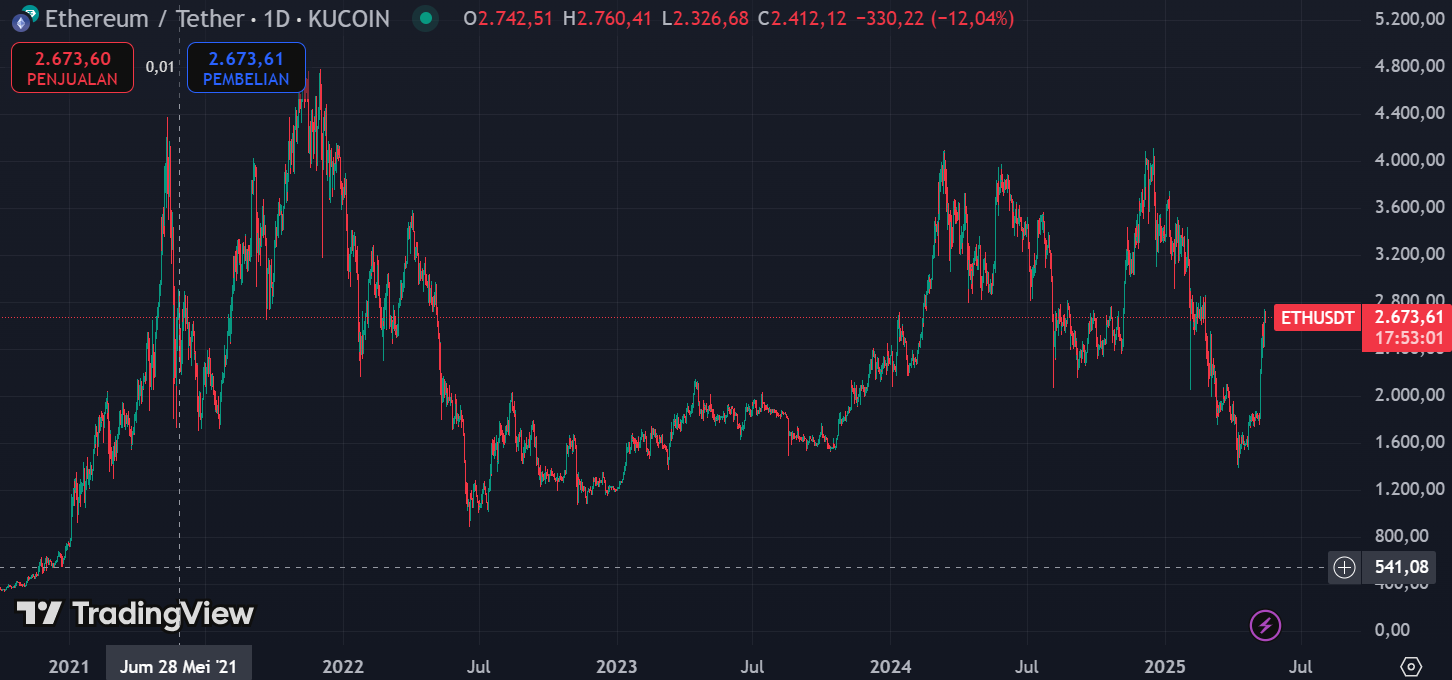

### **BTC Real data vs Scraping data**

In [8]:
fig = go.Figure()
fig.add_trace(go.Candlestick(x=df.index,
                open=df['open_BTC_USDT'],
                high=df['high_BTC_USDT'],
                low=df['low_BTC_USDT'],
                close=df['close_BTC_USDT'],
                name='BTC/USDT'))
fig.update_layout(title='BTC Price (BTC/USDT)', xaxis_title='Date', yaxis_title='Price (USDT)')
fig.show()

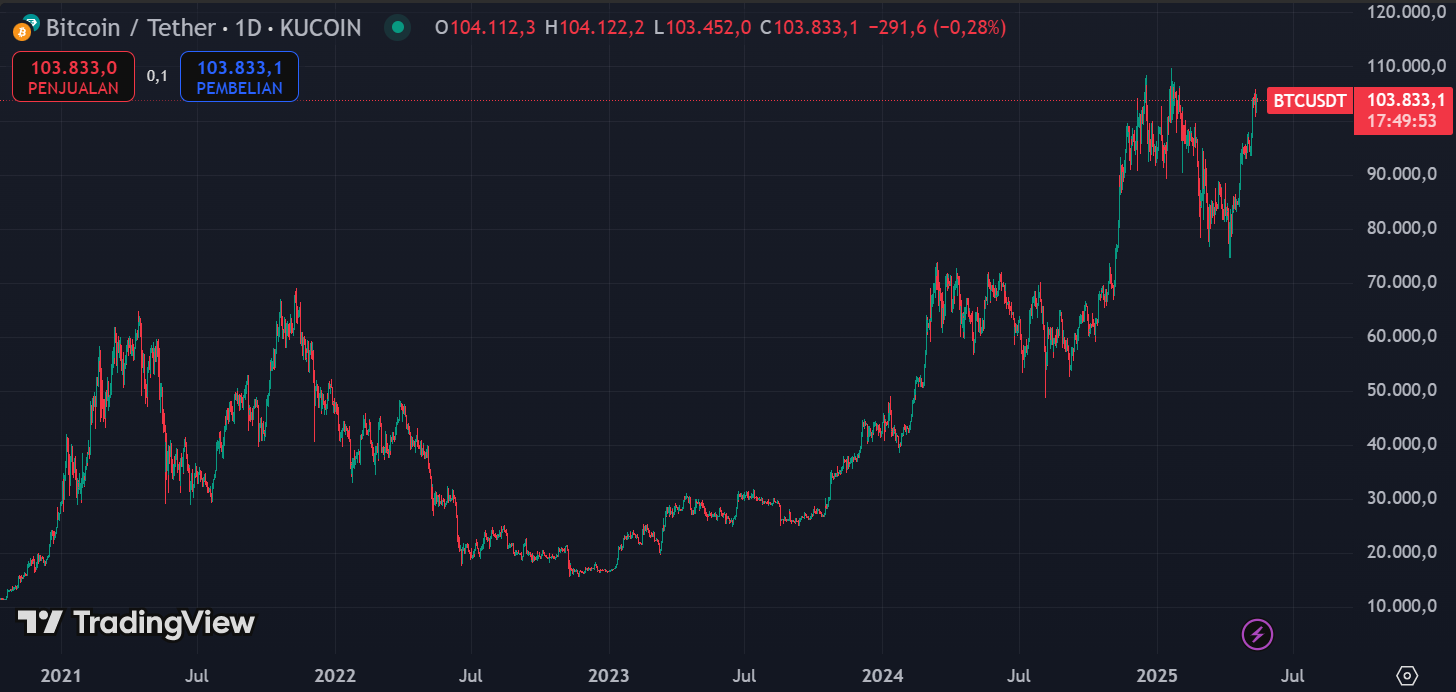

### Check Missing Value

In [11]:
df.drop(columns=['CN_Inflation_sentiment',
 'typical_price_ETH_USDT',
 'typical_price_BTC_USDT',
 'avg_price_ETH_USDT',
 'avg_price_BTC_USDT',
 'close_change_ETH_USDT',
 'close_change_BTC_USDT',
 'close_pct_change_ETH_USDT',
 'close_pct_change_BTC_USDT',
 'CN_Inflation_zscore',
 'CN_Inflation',
 'JP_Inflation_zscore',
 'JP_Inflation_sentiment',
 'DE_inflation',
 'DE_inflation_sentiment',
 'DE_inflation_zscore',
 'UK_inflation_zscore',
 'UK_inflation',
 'UK_inflation_sentiment',
 'FR_inflation_zscore',
 'FR_inflation',
 'FR_inflation_sentiment',
 'KR_Inflation',
 'KR_Inflation_zscore',
 'KR_Inflation_sentiment',
 'JP_Inflation',
 'DE_GDP_zscore',
 'US_GDP',
 'US_GDP_sentiment',
 'JP_GDP',
 'JP_GDP_zscore',
 'FR_GDP_sentiment',
 'FR_GDP_zscore',
 'DE_GDP_sentiment',
 'DE_GDP',
 'FR_GDP',
 'US_GDP_zscore',
 'JP_GDP_sentiment'], inplace=True)

KeyError: "['CN_Inflation_sentiment', 'typical_price_ETH_USDT', 'typical_price_BTC_USDT', 'avg_price_ETH_USDT', 'avg_price_BTC_USDT', 'close_change_ETH_USDT', 'close_change_BTC_USDT', 'close_pct_change_ETH_USDT', 'close_pct_change_BTC_USDT', 'CN_Inflation_zscore', 'CN_Inflation', 'JP_Inflation_zscore', 'JP_Inflation_sentiment', 'DE_inflation', 'DE_inflation_sentiment', 'DE_inflation_zscore', 'UK_inflation_zscore', 'UK_inflation', 'UK_inflation_sentiment', 'FR_inflation_zscore', 'FR_inflation', 'FR_inflation_sentiment', 'KR_Inflation', 'KR_Inflation_zscore', 'KR_Inflation_sentiment', 'JP_Inflation', 'DE_GDP_zscore', 'US_GDP', 'US_GDP_sentiment', 'JP_GDP', 'JP_GDP_zscore', 'FR_GDP_sentiment', 'FR_GDP_zscore', 'DE_GDP_sentiment', 'DE_GDP', 'FR_GDP', 'US_GDP_zscore', 'JP_GDP_sentiment'] not found in axis"

In [10]:
df.isnull().sum().sort_values(ascending=False)

JP_unemployment_sentiment    0
timestamp                    0
open_ETH_USDT                0
high_ETH_USDT                0
low_ETH_USDT                 0
                            ..
low_BTC_USDT                 0
close_BTC_USDT               0
volume_BTC_USDT              0
year                         0
month                        0
Length: 69, dtype: int64

### Overview

In [12]:
df

timestamp  open_ETH_USDT  high_ETH_USDT  low_ETH_USDT  \
1     2020-01-01 01:00:00         128.90         130.60        128.88   
2     2020-01-01 02:00:00         130.58         130.96        130.41   
3     2020-01-01 03:00:00         130.87         130.93        129.97   
4     2020-01-01 04:00:00         130.17         130.66        130.17   
5     2020-01-01 05:00:00         130.20         130.39        130.18   
...                   ...            ...            ...           ...   
47573 2025-06-05 05:00:00        2630.39        2631.45       2608.24   
47574 2025-06-05 06:00:00        2613.03        2617.83       2601.91   
47575 2025-06-05 07:00:00        2604.81        2614.91       2601.17   
47576 2025-06-05 08:00:00        2604.14        2610.18       2598.13   
47577 2025-06-05 09:00:00        2605.25        2610.18       2601.59   

       close_ETH_USDT  volume_ETH_USDT  open_BTC_USDT  high_BTC_USDT  \
1              130.59       482.740070         7180.5         7225.1   
2              130.87       354.911942         7213.8         7242.6   
3              130.16       735.020696         7241.6         7243.2   
4              130.22       259.297509         7225.4         7229.3   
5              130.29       116.087078         7220.7         7228.3   
...               ...              ...            ...            ...   
47573         2613.49      1580.206197       105170.1       105185.2   
47574         2604.28      2290.118632       104651.2       104697.2   
47575         2603.86      1871.523293       104459.9       104629.1   
47576         2605.25      1652.740389       104512.7       104673.7   
47577         2605.43       671.973365       104669.2       104816.3   

       low_BTC_USDT  close_BTC_USDT  ...  KR_CPI_sentiment    JP_CPI  \
1            7179.9          7213.7  ...                -1  0.595558   
2            7213.5          7241.6  ...                -1  0.595558   
3            7221.6          7225.4  ...                -1  0.595558   
4            7218.6          7220.9  ...                -1  0.595558   
5            7220.4          7223.8  ...                -1  0.595558   
...             ...             ...  ...               ...       ...   
47573      104577.1        104651.2  ...                 0  0.082109   
47574      104376.3        104459.9  ...                 0  0.082109   
47575      104423.8        104512.7  ...                 0  0.082109   
47576      104416.6        104669.1  ...                 0  0.082109   
47577      104667.4        104685.7  ...                 0  0.082109   

       JP_CPI_zscore  JP_CPI_sentiment  JP_fund_rate  JP_fund_rate_zscore  \
1           2.187843                 1       0.02100            -0.186542   
2           2.187843                 1       0.02100            -0.186542   
3           2.187843                 1       0.02100            -0.186542   
4           2.187843                 1       0.02100            -0.186542   
5           2.187843                 1       0.02100            -0.186542   
...              ...               ...           ...                  ...   
47573       0.233495                 0       0.82091             3.210330   
47574       0.233495                 0       0.82091             3.210330   
47575       0.233495                 0       0.82091             3.210330   
47576       0.233495                 0       0.82091             3.210330   
47577       0.233495                 0       0.82091             3.210330   

       JP_fund_rate_sentiment  JP_unemployment  JP_unemployment_zscore  \
1                           0              2.4               -1.356233   
2                           0              2.4               -1.356233   
3                           0              2.4               -1.356233   
4                           0              2.4               -1.356233   
5                           0              2.4               -1.356233   
...                       ...           

### Check Correlations

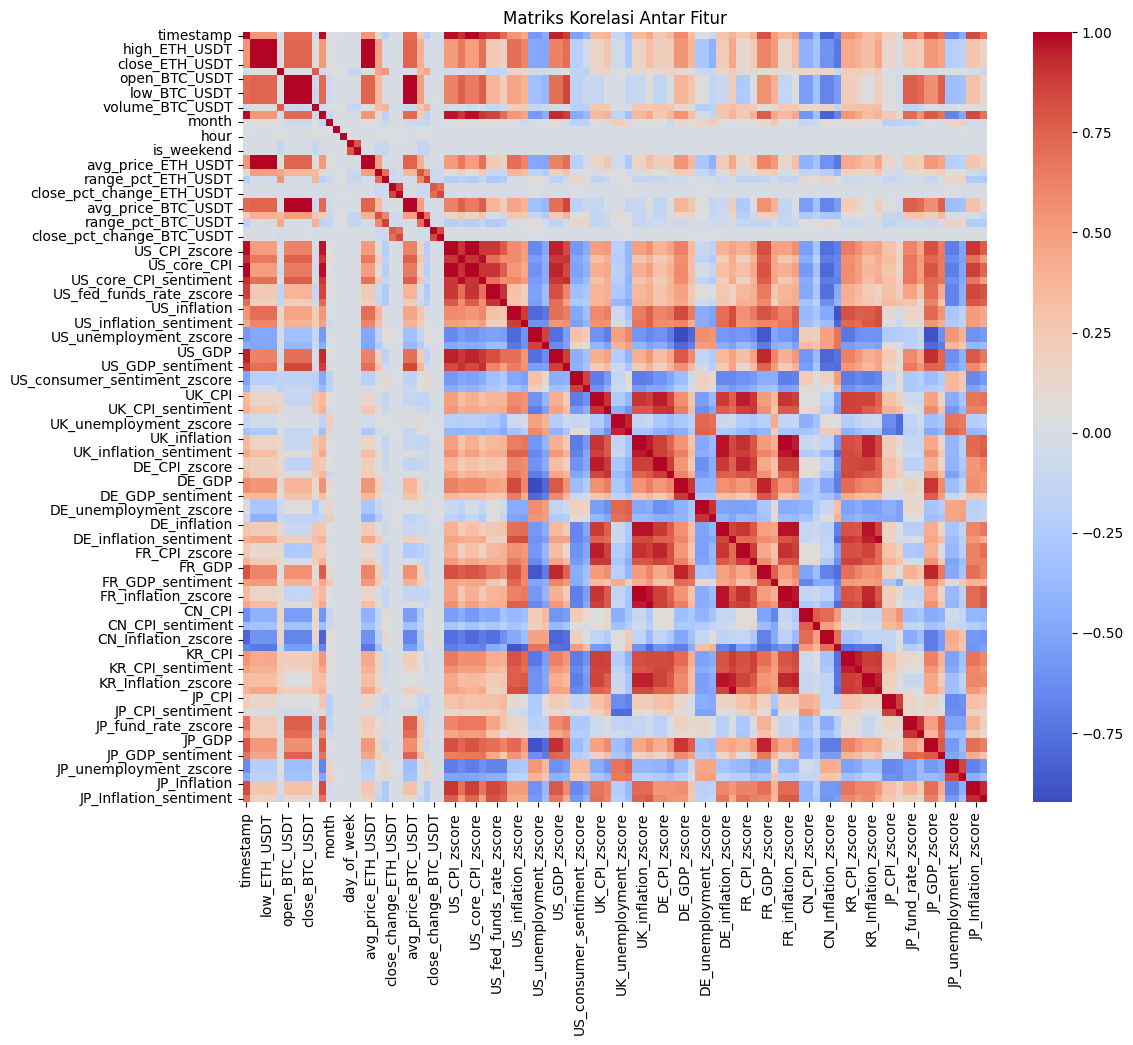

In [12]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 10))
sns.heatmap(df.corr(), annot=False, cmap='coolwarm', fmt=".4f")
plt.title('Matriks Korelasi Antar Fitur')
plt.show()

## **Pre-processing**

### **Load Data**

In [13]:
df = df.copy()
df['timestamp'] = pd.to_datetime(df['timestamp'])
df = df.set_index('timestamp').sort_index()

print("\nDataset Information:")
print(f"Shape: {df.shape}")
print(f"Date Range: {df.index.min()} to {df.index.max()}")
print(f"Total Trading Days: {len(df)}")


Dataset Information:
Shape: (47577, 68)
Date Range: 2020-01-01 01:00:00 to 2025-06-05 09:00:00
Total Trading Days: 47577


### **Cek Runtutan Waktu**

In [14]:
full_idx = pd.date_range(
    start=df.index.min(),
    end  =df.index.max(),
    freq ='h'
)

missing_dates = full_idx.difference(df.index)

print(f"Jumlah tanggal hilang: {len(missing_dates)}")
print(missing_dates)

Jumlah tanggal hilang: 0
DatetimeIndex([], dtype='datetime64[ns]', freq='h')


In [15]:
fig = make_subplots(rows=2, cols=1, shared_xaxes=True,
                    subplot_titles=('ETH/USDT Price', 'BTC/USDT Price'))

fig.add_trace(go.Candlestick(x=df.index[-1000:],
                             open=df['open_ETH_USDT'][-1000:],
                             high=df['high_ETH_USDT'][-1000:],
                             low=df['low_ETH_USDT'][-1000:],
                             close=df['close_ETH_USDT'][-1000:],
                             name='ETH/USDT'), row=1, col=1)

fig.add_trace(go.Candlestick(x=df.index[-1000:],
                             open=df['open_BTC_USDT'][-1000:],
                             high=df['high_BTC_USDT'][-1000:],
                             low=df['low_BTC_USDT'][-1000:],
                             close=df['close_BTC_USDT'][-1000:],
                             name='BTC/USDT'), row=2, col=1)

fig.update_layout(height=800, title='Cryptocurrency Price Movements (Last 1000 hours)')
fig.show()

## **Features Engineering and Features Selection**

### **Set Seed**

In [16]:
def set_seed(seed):
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

    print("PyTorch version:", torch.__version__)
    print("CUDA available:", torch.cuda.is_available())
    print("Number of GPUs:", torch.cuda.device_count())
    os.environ['PYTHONHASHSEED'] = str(seed)

set_seed(9001)

PyTorch version: 2.6.0+cu124
CUDA available: True
Number of GPUs: 2


### **Features Engineering**

In [17]:
def add_technical_indicators(df, price_col='close_ETH_USDT'):
    
    df['sma_7'] = ta.trend.sma_indicator(df[price_col], window=7)
    df['sma_14'] = ta.trend.sma_indicator(df[price_col], window=14)
    df['sma_30'] = ta.trend.sma_indicator(df[price_col], window=30)
    
    df['ema_7'] = ta.trend.ema_indicator(df[price_col], window=7)
    df['ema_14'] = ta.trend.ema_indicator(df[price_col], window=14)
    df['ema_30'] = ta.trend.ema_indicator(df[price_col], window=30)
    
    bb = ta.volatility.BollingerBands(close=df[price_col], window=20, window_dev=2)
    df['bb_upper'] = bb.bollinger_hband()
    df['bb_middle'] = bb.bollinger_mavg()
    df['bb_lower'] = bb.bollinger_lband()
    df['bb_width'] = bb.bollinger_wband()
    df['bb_pband'] = bb.bollinger_pband()
    
    df['rsi_14'] = ta.momentum.RSIIndicator(close=df[price_col], window=14).rsi()
    
    macd = ta.trend.MACD(close=df[price_col])
    df['macd'] = macd.macd()
    df['macd_signal'] = macd.macd_signal()
    df['macd_diff'] = macd.macd_diff()
    
    df['volume_sma_10'] = ta.volume.volume_weighted_average_price(
        high=df['high_ETH_USDT'], 
        low=df['low_ETH_USDT'], 
        close=df[price_col], 
        volume=df['volume_ETH_USDT'], 
        window=10
    )
    
    df['atr_14'] = ta.volatility.AverageTrueRange(
        high=df['high_ETH_USDT'],
        low=df['low_ETH_USDT'],
        close=df[price_col],
        window=14
    ).average_true_range()
    
    stoch = ta.momentum.StochasticOscillator(
        high=df['high_ETH_USDT'],
        low=df['low_ETH_USDT'],
        close=df[price_col],
        window=14
    )
    df['stoch_k'] = stoch.stoch()
    df['stoch_d'] = stoch.stoch_signal()
    
    return df

def add_lag_features(df, columns, lags=[1, 2, 3, 4, 5, 6, 12, 24]):
    for col in columns:
        for lag in lags:
            df[f'{col}_lag_{lag}'] = df[col].shift(lag)
    return df

def add_rolling_features(df, columns, windows=[6, 12, 24, 48]):
    for col in columns:
        for window in windows:
            df[f'{col}_rolling_mean_{window}'] = df[col].rolling(window=window).mean()
            df[f'{col}_rolling_std_{window}'] = df[col].rolling(window=window).std()
            df[f'{col}_rolling_min_{window}'] = df[col].rolling(window=window).min()
            df[f'{col}_rolling_max_{window}'] = df[col].rolling(window=window).max()
    return df

df = add_technical_indicators(df)

lag_columns = ['close_ETH_USDT', 'volume_ETH_USDT', 'close_BTC_USDT', 'rsi_14', 'macd']
df = add_lag_features(df, lag_columns)

rolling_columns = ['close_ETH_USDT', 'volume_ETH_USDT', 'atr_14']
df = add_rolling_features(df, rolling_columns)

df['eth_btc_ratio'] = df['close_ETH_USDT'] / df['close_BTC_USDT']
df['high_low_ratio'] = df['high_ETH_USDT'] / df['low_ETH_USDT']

df = df.ffill().bfill()
print(f"Dataset shape after feature engineering: {df.shape}")

/usr/local/lib/python3.11/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning:

invalid value encountered in greater

/usr/local/lib/python3.11/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning:

invalid value encountered in less

/tmp/ipykernel_35/4253596901.py:61: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

/tmp/ipykernel_35/4253596901.py:62: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

/tmp/ipykernel_35/4253596901.py:63: PerformanceWarning:

DataFrame is highly fragmented.  This is

Dataset shape after feature engineering: (47577, 177)


In [18]:
df.isna().sum().sort_values(ascending=False)

high_low_ratio            0
atr_14_rolling_min_6      0
atr_14_rolling_max_6      0
atr_14_rolling_mean_12    0
atr_14_rolling_std_12     0
                         ..
volume_ETH_USDT           0
open_BTC_USDT             0
high_BTC_USDT             0
low_BTC_USDT              0
close_BTC_USDT            0
Length: 177, dtype: int64

#### **Visualize ETH with Technical Indicator**

In [19]:
def plot_technical_indicators(df, coin_pair='ETH_USDT', start_idx=-500):
    fig = make_subplots(rows=4, cols=1, shared_xaxes=True,
                        vertical_spacing=0.03,
                        row_heights=[0.5, 0.15, 0.15, 0.2],
                        subplot_titles=(f'{coin_pair} Price with MA & BB',
                                      'RSI', 'MACD', 'Volume'))
    
    fig.add_trace(go.Candlestick(x=df.index[start_idx:],
                                 open=df[f'open_{coin_pair}'][start_idx:],
                                 high=df[f'high_{coin_pair}'][start_idx:],
                                 low=df[f'low_{coin_pair}'][start_idx:],
                                 close=df[f'close_{coin_pair}'][start_idx:],
                                 name='Price'), row=1, col=1)
    
    fig.add_trace(go.Scatter(x=df.index[start_idx:],
                            y=df[f'sma_14'][start_idx:],
                            name='SMA14', line=dict(color='blue')), row=1, col=1)
    
    fig.add_trace(go.Scatter(x=df.index[start_idx:],
                            y=df[f'ema_14'][start_idx:],
                            name='EMA14', line=dict(color='orange')), row=1, col=1)
    
    fig.add_trace(go.Scatter(x=df.index[start_idx:],
                            y=df[f'bb_upper'][start_idx:],
                            name='BB Upper', line=dict(color='gray', dash='dash')), row=1, col=1)
    
    fig.add_trace(go.Scatter(x=df.index[start_idx:],
                            y=df[f'bb_lower'][start_idx:],
                            name='BB Lower', line=dict(color='gray', dash='dash'),
                            fill='tonexty', fillcolor='rgba(128,128,128,0.2)'), row=1, col=1)
    
    fig.add_trace(go.Scatter(x=df.index[start_idx:],
                            y=df[f'rsi_14'][start_idx:],
                            name='RSI', line=dict(color='purple')), row=2, col=1)
    
    fig.add_hline(y=70, line_dash="dash", line_color="red", row=2, col=1)
    fig.add_hline(y=30, line_dash="dash", line_color="green", row=2, col=1)

    fig.add_trace(go.Scatter(x=df.index[start_idx:],
                            y=df[f'macd'][start_idx:],
                            name='MACD', line=dict(color='blue')), row=3, col=1)
    
    fig.add_trace(go.Scatter(x=df.index[start_idx:],
                            y=df[f'macd_signal'][start_idx:],
                            name='Signal', line=dict(color='red')), row=3, col=1)
    
    fig.add_trace(go.Bar(x=df.index[start_idx:],
                        y=df[f'volume_{coin_pair}'][start_idx:],
                        name='Volume'), row=4, col=1)
    
    fig.update_layout(height=1000, title=f'{coin_pair} Technical Analysis')
    fig.update_xaxes(rangeslider_visible=False)
    fig.show()

plot_technical_indicators(df, 'ETH_USDT', -500)


### **Features Selection using LightGBM**

Performing feature selection...


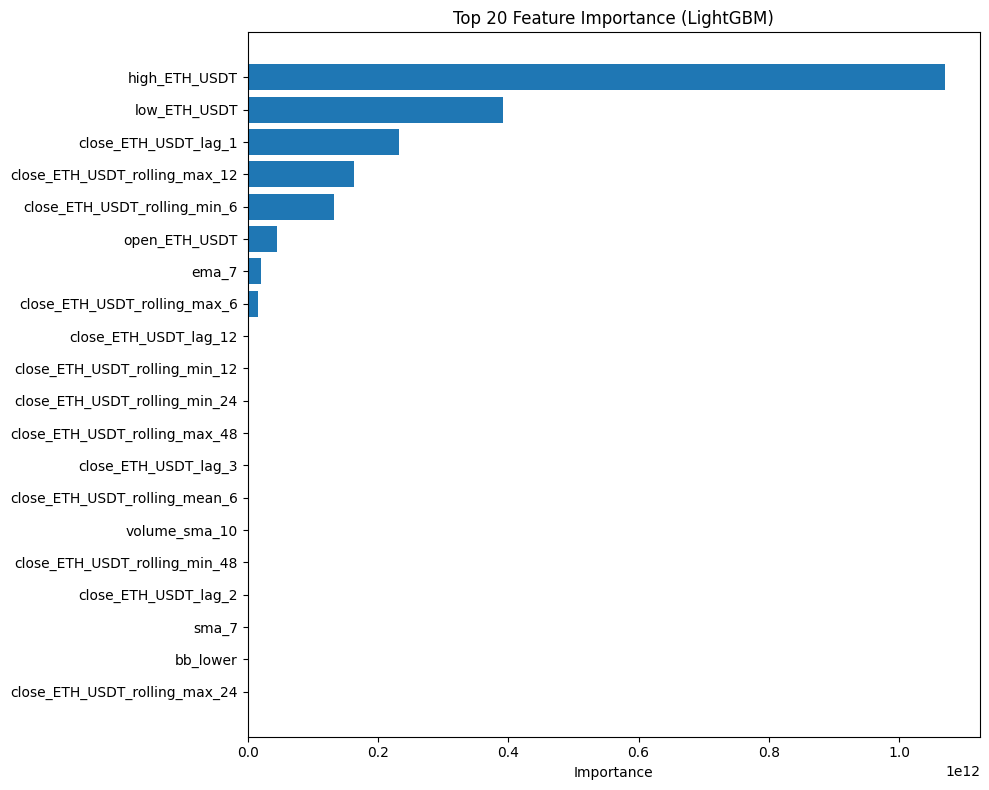

Selected 80 features


In [20]:
def select_features_lightgbm(X, y, n_features=100):
    scaler_fs = RobustScaler()
    X_scaled = scaler_fs.fit_transform(X)
    
    lgb_params = {
        'objective': 'regression',
        'metric': 'rmse',
        'boosting_type': 'gbdt',
        'num_leaves': 31,
        'learning_rate': 0.01,
        'feature_fraction': 0.9,
        'bagging_fraction': 0.8,
        'bagging_freq': 5,
        'verbose': -1,
        'random_state': 9001
    }
    
    lgb_train = lgb.Dataset(X_scaled, y)
    model = lgb.train(lgb_params, lgb_train, num_boost_round=100)
    
    importance = model.feature_importance(importance_type='gain')
    feature_importance = pd.DataFrame({
        'feature': X.columns,
        'importance': importance
    }).sort_values('importance', ascending=False)
    
    top_features = feature_importance.head(n_features)['feature'].tolist()
    
    plt.figure(figsize=(10, 8))
    plt.barh(feature_importance.head(20)['feature'], feature_importance.head(20)['importance'])
    plt.xlabel('Importance')
    plt.title('Top 20 Feature Importance (LightGBM)')
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.show()
    
    return top_features, scaler_fs

feature_cols = [col for col in df.columns if col not in ['timestamp', 'close_ETH_USDT']]
X = df[feature_cols]
y = df['close_ETH_USDT']

print("Performing feature selection...")
selected_features, scaler_fs = select_features_lightgbm(X, y, n_features=80)
print(f"Selected {len(selected_features)} features")

X_selected = X[selected_features]

## **Data Preparation and Scaling**

### **PurgeKFold**

/tmp/ipykernel_35/2282107130.py:44: UserWarning:

Creating legend with loc="best" can be slow with large amounts of data.

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning:

Creating legend with loc="best" can be slow with large amounts of data.



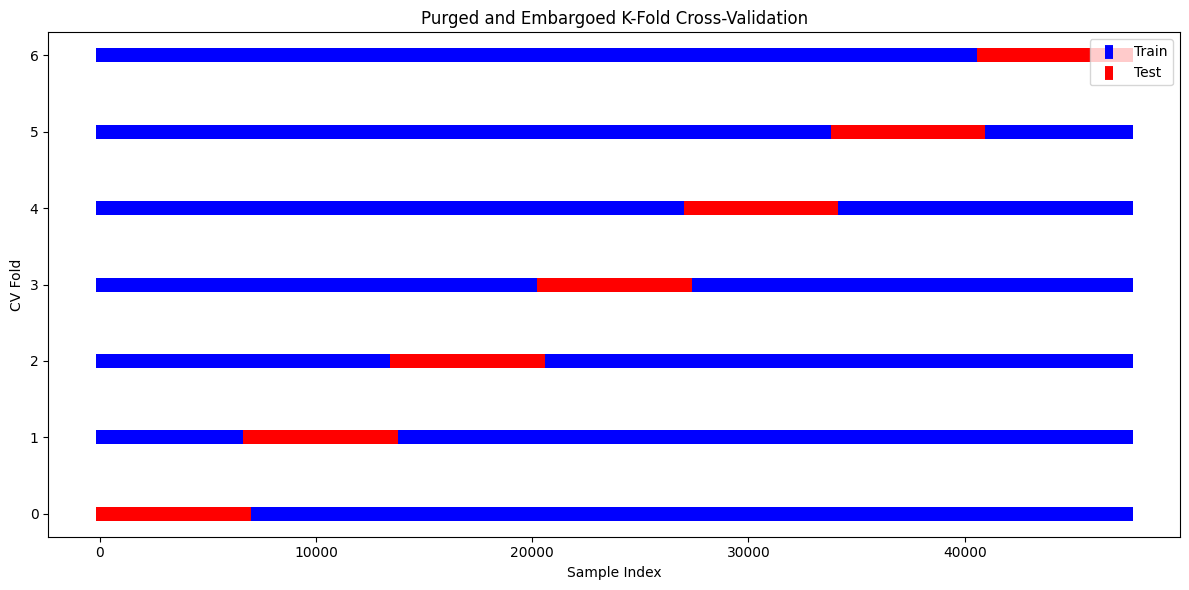

In [21]:
class PurgedKFold:
    def __init__(self, n_splits=7, purge_pct=0.001, embargo_pct=0.0006):
        self.n_splits = n_splits
        self.purge_pct = purge_pct
        self.embargo_pct = embargo_pct
    
    def split(self, X, y=None, groups=None):
        n_samples = len(X)
        indices = np.arange(n_samples)
        embargo_size = int(n_samples * self.embargo_pct)
        purge_size = int(n_samples * self.purge_pct)
        
        test_starts = [(n_samples // self.n_splits) * i for i in range(self.n_splits)]
        test_ends = [(n_samples // self.n_splits) * (i + 1) for i in range(self.n_splits)]
        test_ends[-1] = n_samples
        
        for i in range(self.n_splits):
            test_start = test_starts[i]
            test_end = test_ends[i]
            
            test_indices = indices[test_start:test_end]
            
            train_indices = []
            
            if test_start > embargo_size:
                train_indices.extend(indices[:test_start - embargo_size])
            
            if test_end + purge_size < n_samples:
                train_indices.extend(indices[test_end + purge_size:])
            
            yield np.array(train_indices), test_indices

def plot_cv_splits(X, cv):
    fig, ax = plt.subplots(figsize=(12, 6))
    
    for i, (train_idx, test_idx) in enumerate(cv.split(X)):
        ax.scatter(train_idx, [i] * len(train_idx), c='blue', marker='_', lw=10, label='Train' if i == 0 else '')
        ax.scatter(test_idx, [i] * len(test_idx), c='red', marker='_', lw=10, label='Test' if i == 0 else '')
    
    ax.set_xlabel('Sample Index')
    ax.set_ylabel('CV Fold')
    ax.set_title('Purged and Embargoed K-Fold Cross-Validation')
    ax.legend()
    plt.tight_layout()
    plt.show()

cv = PurgedKFold(n_splits=7, purge_pct=0.001, embargo_pct=0.006)
plot_cv_splits(X_selected, cv)

### **Data Prep**

In [22]:
class TimeSeriesDataset(Dataset):
    def __init__(self, X, y, sequence_length, prediction_horizon):
        self.X = X
        self.y = y
        self.sequence_length = sequence_length
        self.prediction_horizon = prediction_horizon
        
    def __len__(self):
        return len(self.X) - self.sequence_length - self.prediction_horizon + 1
    
    def __getitem__(self, idx):
        X_seq = self.X[idx:idx + self.sequence_length]
        y_seq = self.y[idx + self.sequence_length:idx + self.sequence_length + self.prediction_horizon]
        
        return torch.FloatTensor(X_seq), torch.FloatTensor(y_seq)

def prepare_data_for_training(X, y, sequence_length=48, prediction_horizon=3, train_size=0.8, val_size=0.1):
    
    n_samples = len(X)
    train_end = int(n_samples * train_size)
    val_end = int(n_samples * (train_size + val_size))
    
    X_train, y_train = X[:train_end], y[:train_end]
    X_val, y_val = X[train_end:val_end], y[train_end:val_end]
    X_test, y_test = X[val_end:], y[val_end:]
    
    scaler_X = RobustScaler()
    scaler_y = RobustScaler()
    
    X_train_scaled = scaler_X.fit_transform(X_train)
    y_train_scaled = scaler_y.fit_transform(y_train.values.reshape(-1, 1)).ravel()
    
    X_val_scaled = scaler_X.transform(X_val)
    y_val_scaled = scaler_y.transform(y_val.values.reshape(-1, 1)).ravel()
    
    X_test_scaled = scaler_X.transform(X_test)
    y_test_scaled = scaler_y.transform(y_test.values.reshape(-1, 1)).ravel()
    
    train_dataset = TimeSeriesDataset(X_train_scaled, y_train_scaled, sequence_length, prediction_horizon)
    val_dataset = TimeSeriesDataset(X_val_scaled, y_val_scaled, sequence_length, prediction_horizon)
    test_dataset = TimeSeriesDataset(X_test_scaled, y_test_scaled, sequence_length, prediction_horizon)
    
    return train_dataset, val_dataset, test_dataset, scaler_X, scaler_y

sequence_length = 48 
prediction_horizon = 3  

train_dataset, val_dataset, test_dataset, scaler_X, scaler_y = prepare_data_for_training(
    X_selected, y, sequence_length, prediction_horizon
)

print(f"Train samples: {len(train_dataset)}")
print(f"Validation samples: {len(val_dataset)}")
print(f"Test samples: {len(test_dataset)}")

Train samples: 38011
Validation samples: 4708
Test samples: 4708


## **Model Architectures**

### **LSTM Class**

In [23]:
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size, 
                 dropout=0.2, bidirectional=True, attention=True):
        super(LSTMModel, self).__init__()
        
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.bidirectional = bidirectional
        self.attention = attention
        
        self.lstm = nn.LSTM(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout if num_layers > 1 else 0,
            bidirectional=bidirectional
        )
        
        lstm_output_size = hidden_size * 2 if bidirectional else hidden_size
        
        if attention:
            self.attention_layer = nn.MultiheadAttention(
                embed_dim=lstm_output_size,
                num_heads=8,
                dropout=dropout,
                batch_first=True
            )
        
        self.fc1 = nn.Linear(lstm_output_size, hidden_size)
        self.dropout1 = nn.Dropout(dropout)
        self.fc2 = nn.Linear(hidden_size, hidden_size // 2)
        self.dropout2 = nn.Dropout(dropout)
        self.fc3 = nn.Linear(hidden_size // 2, output_size)
        
        self.relu = nn.ReLU()
        self.layer_norm1 = nn.LayerNorm(hidden_size)
        self.layer_norm2 = nn.LayerNorm(hidden_size // 2)
        
    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        
        if self.attention:
            attn_out, _ = self.attention_layer(lstm_out, lstm_out, lstm_out)
            lstm_out = lstm_out + attn_out  
        
        if self.bidirectional:
            lstm_out = lstm_out[:, -1, :]
        else:
            lstm_out = lstm_out[:, -1, :]
        
        out = self.fc1(lstm_out)
        out = self.layer_norm1(out)
        out = self.relu(out)
        out = self.dropout1(out)
        
        out = self.fc2(out)
        out = self.layer_norm2(out)
        out = self.relu(out)
        out = self.dropout2(out)
        
        out = self.fc3(out)
        
        return out

### **GRU Class**

In [24]:
class GRUModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size, 
                 dropout=0.2, bidirectional=True, attention=True):
        super(GRUModel, self).__init__()
        
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.bidirectional = bidirectional
        self.attention = attention
        
        self.gru = nn.GRU(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout if num_layers > 1 else 0,
            bidirectional=bidirectional
        )
        
        gru_output_size = hidden_size * 2 if bidirectional else hidden_size
        
        if attention:
            self.attention_layer = nn.MultiheadAttention(
                embed_dim=gru_output_size,
                num_heads=8,
                dropout=dropout,
                batch_first=True
            )
        
        self.fc1 = nn.Linear(gru_output_size, hidden_size)
        self.dropout1 = nn.Dropout(dropout)
        self.fc2 = nn.Linear(hidden_size, hidden_size // 2)
        self.dropout2 = nn.Dropout(dropout)
        self.fc3 = nn.Linear(hidden_size // 2, output_size)
        
        self.relu = nn.ReLU()
        self.layer_norm1 = nn.LayerNorm(hidden_size)
        self.layer_norm2 = nn.LayerNorm(hidden_size // 2)
        
    def forward(self, x):
        gru_out, _ = self.gru(x)
        
        if self.attention:
            attn_out, _ = self.attention_layer(gru_out, gru_out, gru_out)
            gru_out = gru_out + attn_out
        
        if self.bidirectional:
            gru_out = gru_out[:, -1, :]
        else:
            gru_out = gru_out[:, -1, :]
        
        out = self.fc1(gru_out)
        out = self.layer_norm1(out)
        out = self.relu(out)
        out = self.dropout1(out)
        
        out = self.fc2(out)
        out = self.layer_norm2(out)
        out = self.relu(out)
        out = self.dropout2(out)
        
        out = self.fc3(out)
        
        return out

## **Setup Multi-GPU**

In [25]:
def setup_ddp(rank, world_size):
    os.environ['MASTER_ADDR'] = 'localhost'
    os.environ['MASTER_PORT'] = '12355'
    dist.init_process_group("nccl", rank=rank, world_size=world_size)

def cleanup_ddp():
    dist.destroy_process_group()

class EarlyStopping:
    def __init__(self, patience=10, min_delta=0, restore_best_weights=True):
        self.patience = patience
        self.min_delta = min_delta
        self.restore_best_weights = restore_best_weights
        self.best_model = None
        self.best_loss = None
        self.counter = 0
        self.early_stop = False
        
    def __call__(self, val_loss, model):
        if self.best_loss is None:
            self.best_loss = val_loss
            self.best_model = model.state_dict()
        elif val_loss > self.best_loss - self.min_delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
                if self.restore_best_weights:
                    model.load_state_dict(self.best_model)
        else:
            self.best_loss = val_loss
            self.best_model = model.state_dict()
            self.counter = 0

def train_model_dp(model_class, train_dataset, val_dataset, hyperparams, num_epochs=150):
    model = model_class(
        input_size=hyperparams['input_size'],
        hidden_size=hyperparams['hidden_size'],
        num_layers=hyperparams['num_layers'],
        output_size=hyperparams['output_size'],
        dropout=hyperparams['dropout'],
        bidirectional=hyperparams['bidirectional'],
        attention=hyperparams['attention']
    )
    
    if torch.cuda.device_count() > 1:
        print(f"Using {torch.cuda.device_count()} GPUs with DataParallel")
        model = nn.DataParallel(model)
    
    model = model.cuda()
    
    train_loader = DataLoader(
        train_dataset, 
        batch_size=hyperparams['batch_size'] * torch.cuda.device_count(),  
        num_workers=4,
        pin_memory=True
    )
    
    val_loader = DataLoader(
        val_dataset, 
        batch_size=hyperparams['batch_size'] * torch.cuda.device_count(), 
        shuffle=False, 
        num_workers=4,
        pin_memory=True
    )
    
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), 
                          lr=hyperparams['learning_rate'], 
                          weight_decay=hyperparams['weight_decay'])
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', 
                                                     factor=0.5, patience=5, verbose=True)
    
    scaler = GradScaler()
    early_stopping = EarlyStopping(patience=15)
    
    train_losses = []
    val_losses = []
    
    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0
        
        progress_bar = tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs}')
        for batch_X, batch_y in progress_bar:
            batch_X, batch_y = batch_X.cuda(), batch_y.cuda()
            
            optimizer.zero_grad()
            
            with autocast():
                outputs = model(batch_X)
                loss = criterion(outputs, batch_y)
            
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
            
            train_loss += loss.item()
            progress_bar.set_postfix({'loss': loss.item()})
        
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for batch_X, batch_y in val_loader:
                batch_X, batch_y = batch_X.cuda(), batch_y.cuda()
                outputs = model(batch_X)
                loss = criterion(outputs, batch_y)
                val_loss += loss.item()
        
        avg_train_loss = train_loss / len(train_loader)
        avg_val_loss = val_loss / len(val_loader)
        
        train_losses.append(avg_train_loss)
        val_losses.append(avg_val_loss)
        
        print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}')
        
        scheduler.step(avg_val_loss)
        early_stopping(avg_val_loss, model)
        
        if early_stopping.early_stop:
            print("Early stopping triggered")
            break
    
    return model, train_losses, val_losses

## **Hyperparameter Tuning**

In [49]:
def objective(trial, model_class, train_dataset, val_dataset):
    hyperparams = {
        'input_size': len(selected_features),
        'hidden_size': trial.suggest_int('hidden_size', 128, 256, step=64),
        'num_layers': trial.suggest_int('num_layers', 2, 4),
        'output_size': prediction_horizon,
        'dropout': trial.suggest_float('dropout', 0.1, 0.3),
        'bidirectional': trial.suggest_categorical('bidirectional', [True, False]),
        'attention': trial.suggest_categorical('attention', [True, False]),
        'batch_size': trial.suggest_int('batch_size', 96, 160, step=32),
        'learning_rate': trial.suggest_float('learning_rate', 1e-4, 1e-2, log=True),
        'weight_decay': trial.suggest_float('weight_decay', 1e-4, 1e-2, log=True)
    }
    
    model = model_class(
        input_size=hyperparams['input_size'],
        hidden_size=hyperparams['hidden_size'],
        num_layers=hyperparams['num_layers'],
        output_size=hyperparams['output_size'],
        dropout=hyperparams['dropout'],
        bidirectional=hyperparams['bidirectional'],
        attention=hyperparams['attention']
    ).cuda()
    
    if torch.cuda.device_count() > 1:
        print(f"Menggunakan {torch.cuda.device_count()} GPU!")
        model = nn.DataParallel(model)
        
    train_loader = DataLoader(train_dataset, batch_size=hyperparams['batch_size'], shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=hyperparams['batch_size'], shuffle=False)
    
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=hyperparams['learning_rate'], 
                          weight_decay=hyperparams['weight_decay'])
    
    num_epochs = 20
    best_val_loss = float('inf')
    
    for epoch in range(num_epochs):
        model.train()
        for batch_X, batch_y in train_loader:
            batch_X, batch_y = batch_X.cuda(), batch_y.cuda()
            optimizer.zero_grad()
            outputs = model(batch_X)
            loss = criterion(outputs, batch_y)
            loss.backward()
            optimizer.step()
        
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for batch_X, batch_y in val_loader:
                batch_X, batch_y = batch_X.cuda(), batch_y.cuda()
                outputs = model(batch_X)
                loss = criterion(outputs, batch_y)
                val_loss += loss.item()
        
        avg_val_loss = val_loss / len(val_loader)
        best_val_loss = min(best_val_loss, avg_val_loss)
        
        trial.report(avg_val_loss, epoch)
        if trial.should_prune():
            raise optuna.exceptions.TrialPruned()
    
    return best_val_loss

print("Hyperparameter tuning for LSTM...")
study_lstm = optuna.create_study(direction='minimize', pruner=optuna.pruners.MedianPruner())
study_lstm.optimize(lambda trial: objective(trial, LSTMModel, train_dataset, val_dataset), n_trials=20)

print("Best LSTM hyperparameters:", study_lstm.best_params)

print("\nHyperparameter tuning for GRU...")
study_gru = optuna.create_study(direction='minimize', pruner=optuna.pruners.MedianPruner())
study_gru.optimize(lambda trial: objective(trial, GRUModel, train_dataset, val_dataset), n_trials=20)

print("Best GRU hyperparameters:", study_gru.best_params)

[I 2025-06-10 19:02:55,495] A new study created in memory with name: no-name-79c40a83-1c6c-4c1d-93d1-2a4356f7c54a


Hyperparameter tuning for LSTM...
Menggunakan 2 GPU!


[I 2025-06-10 19:04:37,973] Trial 0 finished with value: 0.0010007702489068884 and parameters: {'hidden_size': 128, 'num_layers': 3, 'dropout': 0.12076173364590244, 'bidirectional': False, 'attention': True, 'batch_size': 128, 'learning_rate': 0.00016616579789186306, 'weight_decay': 0.002589187027678089}. Best is trial 0 with value: 0.0010007702489068884.


Menggunakan 2 GPU!


[I 2025-06-10 19:06:45,874] Trial 1 finished with value: 0.001369944965117611 and parameters: {'hidden_size': 256, 'num_layers': 2, 'dropout': 0.27933437556983487, 'bidirectional': False, 'attention': False, 'batch_size': 96, 'learning_rate': 0.0013466165909350866, 'weight_decay': 0.0033154501956121156}. Best is trial 0 with value: 0.0010007702489068884.


Menggunakan 2 GPU!


[I 2025-06-10 19:09:20,229] Trial 2 finished with value: 0.0014724327094154431 and parameters: {'hidden_size': 128, 'num_layers': 4, 'dropout': 0.16190076162384498, 'bidirectional': True, 'attention': False, 'batch_size': 96, 'learning_rate': 0.0006209503346302692, 'weight_decay': 0.004354754315739947}. Best is trial 0 with value: 0.0010007702489068884.


Menggunakan 2 GPU!


[I 2025-06-10 19:11:28,075] Trial 3 finished with value: 0.0016940928931580856 and parameters: {'hidden_size': 128, 'num_layers': 3, 'dropout': 0.26571884447507343, 'bidirectional': False, 'attention': True, 'batch_size': 96, 'learning_rate': 0.0015047069155961312, 'weight_decay': 0.003835940904566988}. Best is trial 0 with value: 0.0010007702489068884.


Menggunakan 2 GPU!


[I 2025-06-10 19:17:27,836] Trial 4 finished with value: 0.0011054482931892077 and parameters: {'hidden_size': 256, 'num_layers': 4, 'dropout': 0.2065069958207923, 'bidirectional': True, 'attention': True, 'batch_size': 160, 'learning_rate': 0.0004419867946992197, 'weight_decay': 0.003782110636410852}. Best is trial 0 with value: 0.0010007702489068884.


Menggunakan 2 GPU!


[I 2025-06-10 19:17:35,991] Trial 5 pruned. 


Menggunakan 2 GPU!


[I 2025-06-10 19:17:40,183] Trial 6 pruned. 


Menggunakan 2 GPU!


[I 2025-06-10 19:17:46,255] Trial 7 pruned. 


Menggunakan 2 GPU!


[I 2025-06-10 19:18:44,828] Trial 8 pruned. 


Menggunakan 2 GPU!


[I 2025-06-10 19:19:54,208] Trial 9 pruned. 


Menggunakan 2 GPU!


[I 2025-06-10 19:27:10,248] Trial 10 finished with value: 0.0008585245672588211 and parameters: {'hidden_size': 192, 'num_layers': 3, 'dropout': 0.10115000720518663, 'bidirectional': True, 'attention': True, 'batch_size': 128, 'learning_rate': 0.00014199668089101265, 'weight_decay': 0.00038895595281331487}. Best is trial 10 with value: 0.0008585245672588211.


Menggunakan 2 GPU!


[I 2025-06-10 19:34:27,216] Trial 11 finished with value: 0.0009825884551753767 and parameters: {'hidden_size': 192, 'num_layers': 3, 'dropout': 0.10430712471266665, 'bidirectional': True, 'attention': True, 'batch_size': 128, 'learning_rate': 0.00011651933733051748, 'weight_decay': 0.00036691307595087055}. Best is trial 10 with value: 0.0008585245672588211.


Menggunakan 2 GPU!


[I 2025-06-10 19:41:43,642] Trial 12 finished with value: 0.0008756872663758946 and parameters: {'hidden_size': 192, 'num_layers': 3, 'dropout': 0.1071714418440487, 'bidirectional': True, 'attention': True, 'batch_size': 128, 'learning_rate': 0.00011742382609493743, 'weight_decay': 0.0003611505790626871}. Best is trial 10 with value: 0.0008585245672588211.


Menggunakan 2 GPU!


[I 2025-06-10 19:42:05,462] Trial 13 pruned. 


Menggunakan 2 GPU!


[I 2025-06-10 19:49:22,083] Trial 14 finished with value: 0.0007918731142716432 and parameters: {'hidden_size': 192, 'num_layers': 3, 'dropout': 0.1018560952548388, 'bidirectional': True, 'attention': True, 'batch_size': 128, 'learning_rate': 0.00026488572514407155, 'weight_decay': 0.0005310113104965954}. Best is trial 14 with value: 0.0007918731142716432.


Menggunakan 2 GPU!


[I 2025-06-10 19:49:36,709] Trial 15 pruned. 


Menggunakan 2 GPU!


[I 2025-06-10 19:56:53,358] Trial 16 finished with value: 0.0009138245270052623 and parameters: {'hidden_size': 192, 'num_layers': 3, 'dropout': 0.17485247004159438, 'bidirectional': True, 'attention': True, 'batch_size': 128, 'learning_rate': 0.0002993055116892847, 'weight_decay': 0.00015679236352160933}. Best is trial 14 with value: 0.0007918731142716432.


Menggunakan 2 GPU!


[I 2025-06-10 19:57:20,932] Trial 17 pruned. 


Menggunakan 2 GPU!


[I 2025-06-10 20:00:42,925] Trial 18 finished with value: 0.0008371756510412622 and parameters: {'hidden_size': 256, 'num_layers': 2, 'dropout': 0.2194337360986315, 'bidirectional': True, 'attention': True, 'batch_size': 128, 'learning_rate': 0.0001879884896545686, 'weight_decay': 0.00022099024259740046}. Best is trial 14 with value: 0.0007918731142716432.


Menggunakan 2 GPU!


[I 2025-06-10 20:00:53,122] Trial 19 pruned. 
[I 2025-06-10 20:00:53,123] A new study created in memory with name: no-name-d8ef615a-112d-4d04-82ea-91bf812cbe75


Best LSTM hyperparameters: {'hidden_size': 192, 'num_layers': 3, 'dropout': 0.1018560952548388, 'bidirectional': True, 'attention': True, 'batch_size': 128, 'learning_rate': 0.00026488572514407155, 'weight_decay': 0.0005310113104965954}

Hyperparameter tuning for GRU...
Menggunakan 2 GPU!


[I 2025-06-10 20:02:32,295] Trial 0 finished with value: 0.0010149986376442636 and parameters: {'hidden_size': 128, 'num_layers': 3, 'dropout': 0.16448845477859148, 'bidirectional': True, 'attention': True, 'batch_size': 160, 'learning_rate': 0.0002726888951576335, 'weight_decay': 0.007386068029697989}. Best is trial 0 with value: 0.0010149986376442636.


Menggunakan 2 GPU!


[I 2025-06-10 20:04:08,440] Trial 1 finished with value: 0.0015796408949730297 and parameters: {'hidden_size': 128, 'num_layers': 4, 'dropout': 0.2830591835267111, 'bidirectional': True, 'attention': False, 'batch_size': 160, 'learning_rate': 0.0005623220127215133, 'weight_decay': 0.0010163261833209117}. Best is trial 0 with value: 0.0010149986376442636.


Menggunakan 2 GPU!


[I 2025-06-10 20:05:45,332] Trial 2 finished with value: 0.0018700479461889092 and parameters: {'hidden_size': 256, 'num_layers': 3, 'dropout': 0.22276359070262908, 'bidirectional': False, 'attention': False, 'batch_size': 160, 'learning_rate': 0.005264261146016694, 'weight_decay': 0.0006538941559875571}. Best is trial 0 with value: 0.0010149986376442636.


Menggunakan 2 GPU!


[I 2025-06-10 20:07:56,561] Trial 3 finished with value: 0.0011274490316282026 and parameters: {'hidden_size': 128, 'num_layers': 4, 'dropout': 0.1394603173426932, 'bidirectional': False, 'attention': True, 'batch_size': 96, 'learning_rate': 0.001517021564079089, 'weight_decay': 0.0017429008442712618}. Best is trial 0 with value: 0.0010149986376442636.


Menggunakan 2 GPU!


[I 2025-06-10 20:09:33,513] Trial 4 finished with value: 0.001255558974808082 and parameters: {'hidden_size': 128, 'num_layers': 2, 'dropout': 0.17023426096557887, 'bidirectional': False, 'attention': False, 'batch_size': 96, 'learning_rate': 0.0032018808727003745, 'weight_decay': 0.00018352358150593054}. Best is trial 0 with value: 0.0010149986376442636.


Menggunakan 2 GPU!


[I 2025-06-10 20:09:41,255] Trial 5 pruned. 


Menggunakan 2 GPU!


[I 2025-06-10 20:09:50,341] Trial 6 pruned. 


Menggunakan 2 GPU!


[I 2025-06-10 20:09:56,073] Trial 7 pruned. 


Menggunakan 2 GPU!


[I 2025-06-10 20:11:47,399] Trial 8 finished with value: 0.0008802803677099291 and parameters: {'hidden_size': 128, 'num_layers': 2, 'dropout': 0.23887502042130582, 'bidirectional': True, 'attention': False, 'batch_size': 96, 'learning_rate': 0.00015821989191201595, 'weight_decay': 0.0020613577019933955}. Best is trial 8 with value: 0.0008802803677099291.


Menggunakan 2 GPU!


[I 2025-06-10 20:11:54,238] Trial 9 pruned. 


Menggunakan 2 GPU!


[I 2025-06-10 20:12:03,931] Trial 10 pruned. 


Menggunakan 2 GPU!


[I 2025-06-10 20:13:51,323] Trial 11 finished with value: 0.001005346076232633 and parameters: {'hidden_size': 128, 'num_layers': 2, 'dropout': 0.175380425153164, 'bidirectional': True, 'attention': True, 'batch_size': 128, 'learning_rate': 0.00039227745288273095, 'weight_decay': 0.009886091274978465}. Best is trial 8 with value: 0.0008802803677099291.


Menggunakan 2 GPU!


[I 2025-06-10 20:14:07,477] Trial 12 pruned. 


Menggunakan 2 GPU!


[I 2025-06-10 20:14:18,853] Trial 13 pruned. 


Menggunakan 2 GPU!


[I 2025-06-10 20:14:53,123] Trial 14 pruned. 


Menggunakan 2 GPU!


[I 2025-06-10 20:16:45,046] Trial 15 finished with value: 0.000864839730784297 and parameters: {'hidden_size': 128, 'num_layers': 2, 'dropout': 0.14394400548934055, 'bidirectional': True, 'attention': False, 'batch_size': 96, 'learning_rate': 0.000228077708166379, 'weight_decay': 0.00238471423223119}. Best is trial 15 with value: 0.000864839730784297.


Menggunakan 2 GPU!


[I 2025-06-10 20:18:36,957] Trial 16 finished with value: 0.0009271876164712012 and parameters: {'hidden_size': 128, 'num_layers': 2, 'dropout': 0.13135325091027525, 'bidirectional': True, 'attention': False, 'batch_size': 96, 'learning_rate': 0.00010158988140789537, 'weight_decay': 0.0017818685780160825}. Best is trial 15 with value: 0.000864839730784297.


Menggunakan 2 GPU!


[I 2025-06-10 20:18:51,084] Trial 17 pruned. 


Menggunakan 2 GPU!


[I 2025-06-10 20:20:41,951] Trial 18 finished with value: 0.0007515870945644565 and parameters: {'hidden_size': 128, 'num_layers': 2, 'dropout': 0.10327552292640953, 'bidirectional': True, 'attention': False, 'batch_size': 96, 'learning_rate': 0.00027096870944425157, 'weight_decay': 0.001088014897333264}. Best is trial 18 with value: 0.0007515870945644565.


Menggunakan 2 GPU!


[I 2025-06-10 20:20:57,434] Trial 19 pruned. 


Best GRU hyperparameters: {'hidden_size': 128, 'num_layers': 2, 'dropout': 0.10327552292640953, 'bidirectional': True, 'attention': False, 'batch_size': 96, 'learning_rate': 0.00027096870944425157, 'weight_decay': 0.001088014897333264}


## **Training Model with Best Hyperparameters**

In [26]:
if __name__ == '__main__':
    lstm_params = {'hidden_size': 192,
                   'num_layers': 3,
                   'dropout': 0.1018560952548388,
                   'bidirectional': True,
                   'attention': True,
                   'batch_size': 128,
                   'learning_rate': 0.00026488572514407155,
                   'weight_decay': 0.0005310113104965954}
    best_lstm_params = {
        'input_size': len(selected_features),
        'output_size': prediction_horizon,
        **lstm_params
    }
    
    print(f"Training LSTM model on {torch.cuda.device_count()} GPUs...")
    lstm_model, lstm_train_losses, lstm_val_losses = train_model_dp(
        LSTMModel, train_dataset, val_dataset, best_lstm_params, num_epochs=200
    )
    

Training LSTM model on 2 GPUs...
Using 2 GPUs with DataParallel


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning:

The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.

/tmp/ipykernel_35/3745101833.py:73: FutureWarning:

`torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.

Epoch 1/200:   0%|          | 0/149 [00:00<?, ?it/s]/tmp/ipykernel_35/3745101833.py:89: FutureWarning:

`torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.

Epoch 1/200: 100%|██████████| 149/149 [00:08<00:00, 17.07it/s, loss=0.165] 


Epoch [1/200], Train Loss: 0.1765, Val Loss: 0.1775


Epoch 2/200: 100%|██████████| 149/149 [00:05<00:00, 25.71it/s, loss=0.0642]


Epoch [2/200], Train Loss: 0.2442, Val Loss: 0.1320


Epoch 3/200: 100%|██████████| 149/149 [00:05<00:00, 25.38it/s, loss=0.224] 


Epoch [3/200], Train Loss: 0.3165, Val Loss: 0.2354


Epoch 4/200: 100%|██████████| 149/149 [00:05<00:00, 26.02it/s, loss=0.16]   


Epoch [4/200], Train Loss: 0.4936, Val Loss: 0.1977


Epoch 5/200: 100%|██████████| 149/149 [00:05<00:00, 25.19it/s, loss=0.0399] 


Epoch [5/200], Train Loss: 0.3582, Val Loss: 0.1168


Epoch 6/200: 100%|██████████| 149/149 [00:05<00:00, 25.28it/s, loss=0.0359]


Epoch [6/200], Train Loss: 0.3400, Val Loss: 0.1147


Epoch 7/200: 100%|██████████| 149/149 [00:05<00:00, 25.52it/s, loss=0.0279]


Epoch [7/200], Train Loss: 0.3271, Val Loss: 0.1102


Epoch 8/200: 100%|██████████| 149/149 [00:05<00:00, 26.13it/s, loss=0.0637] 


Epoch [8/200], Train Loss: 0.2637, Val Loss: 0.1235


Epoch 9/200: 100%|██████████| 149/149 [00:05<00:00, 25.71it/s, loss=0.0324] 


Epoch [9/200], Train Loss: 0.2616, Val Loss: 0.1332


Epoch 10/200: 100%|██████████| 149/149 [00:05<00:00, 25.06it/s, loss=0.0229]


Epoch [10/200], Train Loss: 0.2937, Val Loss: 0.0871


Epoch 11/200: 100%|██████████| 149/149 [00:05<00:00, 25.19it/s, loss=0.283]  


Epoch [11/200], Train Loss: 0.2296, Val Loss: 0.3711


Epoch 12/200: 100%|██████████| 149/149 [00:05<00:00, 25.84it/s, loss=0.0598] 


Epoch [12/200], Train Loss: 0.2482, Val Loss: 0.0649


Epoch 13/200: 100%|██████████| 149/149 [00:05<00:00, 25.89it/s, loss=0.0823]


Epoch [13/200], Train Loss: 0.2035, Val Loss: 0.0257


Epoch 14/200: 100%|██████████| 149/149 [00:06<00:00, 24.81it/s, loss=0.0313] 


Epoch [14/200], Train Loss: 0.1677, Val Loss: 0.0225


Epoch 15/200: 100%|██████████| 149/149 [00:06<00:00, 24.79it/s, loss=0.042]  


Epoch [15/200], Train Loss: 0.0943, Val Loss: 0.0306


Epoch 16/200: 100%|██████████| 149/149 [00:05<00:00, 24.91it/s, loss=0.021]  


Epoch [16/200], Train Loss: 0.0378, Val Loss: 0.0258


Epoch 17/200: 100%|██████████| 149/149 [00:05<00:00, 25.68it/s, loss=0.0409] 


Epoch [17/200], Train Loss: 0.1452, Val Loss: 0.1013


Epoch 18/200: 100%|██████████| 149/149 [00:05<00:00, 25.75it/s, loss=0.026] 


Epoch [18/200], Train Loss: 0.2978, Val Loss: 0.1030


Epoch 19/200: 100%|██████████| 149/149 [00:05<00:00, 24.98it/s, loss=0.0371] 


Epoch [19/200], Train Loss: 0.2142, Val Loss: 0.0873


Epoch 20/200: 100%|██████████| 149/149 [00:05<00:00, 25.12it/s, loss=0.17]   


Epoch [20/200], Train Loss: 1.0647, Val Loss: 0.2251


Epoch 21/200: 100%|██████████| 149/149 [00:05<00:00, 25.35it/s, loss=0.0347] 


Epoch [21/200], Train Loss: 0.3065, Val Loss: 0.1009


Epoch 22/200: 100%|██████████| 149/149 [00:05<00:00, 27.78it/s, loss=0.0206] 


Epoch [22/200], Train Loss: 0.1474, Val Loss: 0.0430


Epoch 23/200: 100%|██████████| 149/149 [00:05<00:00, 27.38it/s, loss=0.0234] 


Epoch [23/200], Train Loss: 0.0822, Val Loss: 0.0167


Epoch 24/200: 100%|██████████| 149/149 [00:06<00:00, 24.39it/s, loss=0.0141] 


Epoch [24/200], Train Loss: 0.0569, Val Loss: 0.0101


Epoch 25/200: 100%|██████████| 149/149 [00:06<00:00, 24.82it/s, loss=0.0133] 


Epoch [25/200], Train Loss: 0.0580, Val Loss: 0.0066


Epoch 26/200: 100%|██████████| 149/149 [00:05<00:00, 25.28it/s, loss=0.018]  


Epoch [26/200], Train Loss: 0.0335, Val Loss: 0.0076


Epoch 27/200: 100%|██████████| 149/149 [00:05<00:00, 25.98it/s, loss=0.0188] 


Epoch [27/200], Train Loss: 0.0226, Val Loss: 0.0060


Epoch 28/200: 100%|██████████| 149/149 [00:06<00:00, 24.82it/s, loss=0.0202] 


Epoch [28/200], Train Loss: 0.0194, Val Loss: 0.0073


Epoch 29/200: 100%|██████████| 149/149 [00:05<00:00, 25.46it/s, loss=0.0394] 


Epoch [29/200], Train Loss: 0.0207, Val Loss: 0.0169


Epoch 30/200: 100%|██████████| 149/149 [00:05<00:00, 24.88it/s, loss=0.0208] 


Epoch [30/200], Train Loss: 0.0175, Val Loss: 0.0131


Epoch 31/200: 100%|██████████| 149/149 [00:05<00:00, 25.30it/s, loss=0.0258] 


Epoch [31/200], Train Loss: 0.0189, Val Loss: 0.0241


Epoch 32/200: 100%|██████████| 149/149 [00:05<00:00, 25.18it/s, loss=0.0239] 


Epoch [32/200], Train Loss: 0.0181, Val Loss: 0.0182


Epoch 33/200: 100%|██████████| 149/149 [00:06<00:00, 24.52it/s, loss=0.0181] 


Epoch [33/200], Train Loss: 0.0435, Val Loss: 0.0346


Epoch 34/200: 100%|██████████| 149/149 [00:05<00:00, 24.97it/s, loss=0.013]  


Epoch [34/200], Train Loss: 0.0756, Val Loss: 0.0140


Epoch 35/200: 100%|██████████| 149/149 [00:05<00:00, 24.87it/s, loss=0.0117] 


Epoch [35/200], Train Loss: 0.0188, Val Loss: 0.0059


Epoch 36/200: 100%|██████████| 149/149 [00:05<00:00, 24.86it/s, loss=0.00972]


Epoch [36/200], Train Loss: 0.0140, Val Loss: 0.0056


Epoch 37/200: 100%|██████████| 149/149 [00:06<00:00, 24.10it/s, loss=0.0126] 


Epoch [37/200], Train Loss: 0.0130, Val Loss: 0.0058


Epoch 38/200: 100%|██████████| 149/149 [00:05<00:00, 25.13it/s, loss=0.00966]


Epoch [38/200], Train Loss: 0.0126, Val Loss: 0.0057


Epoch 39/200: 100%|██████████| 149/149 [00:05<00:00, 25.13it/s, loss=0.0129] 


Epoch [39/200], Train Loss: 0.0123, Val Loss: 0.0053


Epoch 40/200: 100%|██████████| 149/149 [00:05<00:00, 25.56it/s, loss=0.0138] 


Epoch [40/200], Train Loss: 0.0122, Val Loss: 0.0055


Epoch 41/200: 100%|██████████| 149/149 [00:06<00:00, 24.02it/s, loss=0.0131] 


Epoch [41/200], Train Loss: 0.0118, Val Loss: 0.0059


Epoch 42/200: 100%|██████████| 149/149 [00:05<00:00, 25.18it/s, loss=0.0105] 


Epoch [42/200], Train Loss: 0.0115, Val Loss: 0.0055


Epoch 43/200: 100%|██████████| 149/149 [00:05<00:00, 25.08it/s, loss=0.0157] 


Epoch [43/200], Train Loss: 0.0115, Val Loss: 0.0057


Epoch 44/200: 100%|██████████| 149/149 [00:05<00:00, 25.30it/s, loss=0.014]  


Epoch [44/200], Train Loss: 0.0114, Val Loss: 0.0063


Epoch 45/200: 100%|██████████| 149/149 [00:06<00:00, 24.21it/s, loss=0.0164] 


Epoch [45/200], Train Loss: 0.0120, Val Loss: 0.0115


Epoch 46/200: 100%|██████████| 149/149 [00:05<00:00, 25.09it/s, loss=0.0137] 


Epoch [46/200], Train Loss: 0.0109, Val Loss: 0.0027


Epoch 47/200: 100%|██████████| 149/149 [00:06<00:00, 24.71it/s, loss=0.00879]


Epoch [47/200], Train Loss: 0.0102, Val Loss: 0.0024


Epoch 48/200: 100%|██████████| 149/149 [00:05<00:00, 25.40it/s, loss=0.0127] 


Epoch [48/200], Train Loss: 0.0097, Val Loss: 0.0028


Epoch 49/200: 100%|██████████| 149/149 [00:06<00:00, 24.24it/s, loss=0.0116] 


Epoch [49/200], Train Loss: 0.0096, Val Loss: 0.0025


Epoch 50/200: 100%|██████████| 149/149 [00:05<00:00, 25.05it/s, loss=0.0115] 


Epoch [50/200], Train Loss: 0.0095, Val Loss: 0.0027


Epoch 51/200: 100%|██████████| 149/149 [00:06<00:00, 24.81it/s, loss=0.00976]


Epoch [51/200], Train Loss: 0.0094, Val Loss: 0.0024


Epoch 52/200: 100%|██████████| 149/149 [00:05<00:00, 25.46it/s, loss=0.0105] 


Epoch [52/200], Train Loss: 0.0093, Val Loss: 0.0022


Epoch 53/200: 100%|██████████| 149/149 [00:06<00:00, 24.25it/s, loss=0.00859]


Epoch [53/200], Train Loss: 0.0094, Val Loss: 0.0023


Epoch 54/200: 100%|██████████| 149/149 [00:05<00:00, 25.31it/s, loss=0.0107] 


Epoch [54/200], Train Loss: 0.0091, Val Loss: 0.0024


Epoch 55/200: 100%|██████████| 149/149 [00:05<00:00, 25.39it/s, loss=0.0077] 


Epoch [55/200], Train Loss: 0.0091, Val Loss: 0.0034


Epoch 56/200: 100%|██████████| 149/149 [00:05<00:00, 25.03it/s, loss=0.011]  


Epoch [56/200], Train Loss: 0.0092, Val Loss: 0.0036


Epoch 57/200: 100%|██████████| 149/149 [00:06<00:00, 24.26it/s, loss=0.0109] 


Epoch [57/200], Train Loss: 0.0095, Val Loss: 0.0049


Epoch 58/200: 100%|██████████| 149/149 [00:05<00:00, 25.51it/s, loss=0.0112] 


Epoch [58/200], Train Loss: 0.0101, Val Loss: 0.0042


Epoch 59/200: 100%|██████████| 149/149 [00:05<00:00, 25.17it/s, loss=0.00991]


Epoch [59/200], Train Loss: 0.0111, Val Loss: 0.0039


Epoch 60/200: 100%|██████████| 149/149 [00:06<00:00, 24.56it/s, loss=0.0128] 


Epoch [60/200], Train Loss: 0.0101, Val Loss: 0.0029


Epoch 61/200: 100%|██████████| 149/149 [00:06<00:00, 23.97it/s, loss=0.00975]


Epoch [61/200], Train Loss: 0.0089, Val Loss: 0.0024


Epoch 62/200: 100%|██████████| 149/149 [00:05<00:00, 25.76it/s, loss=0.00834]


Epoch [62/200], Train Loss: 0.0086, Val Loss: 0.0024


Epoch 63/200: 100%|██████████| 149/149 [00:05<00:00, 25.35it/s, loss=0.0135] 


Epoch [63/200], Train Loss: 0.0085, Val Loss: 0.0023


Epoch 64/200: 100%|██████████| 149/149 [00:05<00:00, 25.29it/s, loss=0.00911]


Epoch [64/200], Train Loss: 0.0084, Val Loss: 0.0023


Epoch 65/200: 100%|██████████| 149/149 [00:05<00:00, 26.29it/s, loss=0.0117] 


Epoch [65/200], Train Loss: 0.0086, Val Loss: 0.0020


Epoch 66/200: 100%|██████████| 149/149 [00:05<00:00, 27.22it/s, loss=0.0092] 


Epoch [66/200], Train Loss: 0.0085, Val Loss: 0.0020


Epoch 67/200: 100%|██████████| 149/149 [00:06<00:00, 24.48it/s, loss=0.00839]


Epoch [67/200], Train Loss: 0.0081, Val Loss: 0.0020


Epoch 68/200: 100%|██████████| 149/149 [00:05<00:00, 25.04it/s, loss=0.0123] 


Epoch [68/200], Train Loss: 0.0081, Val Loss: 0.0019


Epoch 69/200: 100%|██████████| 149/149 [00:05<00:00, 25.47it/s, loss=0.0115] 


Epoch [69/200], Train Loss: 0.0081, Val Loss: 0.0020


Epoch 70/200: 100%|██████████| 149/149 [00:05<00:00, 25.02it/s, loss=0.0103] 


Epoch [70/200], Train Loss: 0.0080, Val Loss: 0.0018


Epoch 71/200: 100%|██████████| 149/149 [00:05<00:00, 25.00it/s, loss=0.0133] 


Epoch [71/200], Train Loss: 0.0079, Val Loss: 0.0018


Epoch 72/200: 100%|██████████| 149/149 [00:05<00:00, 25.14it/s, loss=0.0128] 


Epoch [72/200], Train Loss: 0.0078, Val Loss: 0.0018


Epoch 73/200: 100%|██████████| 149/149 [00:06<00:00, 24.34it/s, loss=0.011]  


Epoch [73/200], Train Loss: 0.0079, Val Loss: 0.0018


Epoch 74/200: 100%|██████████| 149/149 [00:06<00:00, 24.72it/s, loss=0.00909]


Epoch [74/200], Train Loss: 0.0080, Val Loss: 0.0018


Epoch 75/200: 100%|██████████| 149/149 [00:06<00:00, 24.63it/s, loss=0.0107] 


Epoch [75/200], Train Loss: 0.0076, Val Loss: 0.0017


Epoch 76/200: 100%|██████████| 149/149 [00:05<00:00, 25.10it/s, loss=0.0109] 


Epoch [76/200], Train Loss: 0.0079, Val Loss: 0.0017


Epoch 77/200: 100%|██████████| 149/149 [00:06<00:00, 24.33it/s, loss=0.0133] 


Epoch [77/200], Train Loss: 0.0077, Val Loss: 0.0018


Epoch 78/200: 100%|██████████| 149/149 [00:06<00:00, 24.37it/s, loss=0.00799]


Epoch [78/200], Train Loss: 0.0075, Val Loss: 0.0019


Epoch 79/200: 100%|██████████| 149/149 [00:05<00:00, 24.90it/s, loss=0.0094] 


Epoch [79/200], Train Loss: 0.0077, Val Loss: 0.0017


Epoch 80/200: 100%|██████████| 149/149 [00:06<00:00, 24.80it/s, loss=0.00974]


Epoch [80/200], Train Loss: 0.0075, Val Loss: 0.0017


Epoch 81/200: 100%|██████████| 149/149 [00:06<00:00, 24.55it/s, loss=0.0101] 


Epoch [81/200], Train Loss: 0.0073, Val Loss: 0.0017


Epoch 82/200: 100%|██████████| 149/149 [00:05<00:00, 25.13it/s, loss=0.0077] 


Epoch [82/200], Train Loss: 0.0075, Val Loss: 0.0017


Epoch 83/200: 100%|██████████| 149/149 [00:05<00:00, 25.02it/s, loss=0.00917]


Epoch [83/200], Train Loss: 0.0074, Val Loss: 0.0017


Epoch 84/200: 100%|██████████| 149/149 [00:06<00:00, 24.73it/s, loss=0.0108] 


Epoch [84/200], Train Loss: 0.0073, Val Loss: 0.0019


Epoch 85/200: 100%|██████████| 149/149 [00:06<00:00, 24.09it/s, loss=0.0096] 


Epoch [85/200], Train Loss: 0.0074, Val Loss: 0.0017


Epoch 86/200: 100%|██████████| 149/149 [00:05<00:00, 25.18it/s, loss=0.0119] 


Epoch [86/200], Train Loss: 0.0076, Val Loss: 0.0017


Epoch 87/200: 100%|██████████| 149/149 [00:05<00:00, 24.89it/s, loss=0.00818]


Epoch [87/200], Train Loss: 0.0076, Val Loss: 0.0016


Epoch 88/200: 100%|██████████| 149/149 [00:05<00:00, 24.90it/s, loss=0.00831]


Epoch [88/200], Train Loss: 0.0073, Val Loss: 0.0016


Epoch 89/200: 100%|██████████| 149/149 [00:06<00:00, 24.30it/s, loss=0.0103] 


Epoch [89/200], Train Loss: 0.0073, Val Loss: 0.0016


Epoch 90/200: 100%|██████████| 149/149 [00:05<00:00, 25.52it/s, loss=0.00914]


Epoch [90/200], Train Loss: 0.0072, Val Loss: 0.0016


Epoch 91/200: 100%|██████████| 149/149 [00:05<00:00, 25.05it/s, loss=0.00941]


Epoch [91/200], Train Loss: 0.0069, Val Loss: 0.0016


Epoch 92/200: 100%|██████████| 149/149 [00:05<00:00, 25.19it/s, loss=0.00853]


Epoch [92/200], Train Loss: 0.0073, Val Loss: 0.0015


Epoch 93/200: 100%|██████████| 149/149 [00:06<00:00, 24.31it/s, loss=0.00833]


Epoch [93/200], Train Loss: 0.0072, Val Loss: 0.0017


Epoch 94/200: 100%|██████████| 149/149 [00:05<00:00, 24.91it/s, loss=0.0096] 


Epoch [94/200], Train Loss: 0.0073, Val Loss: 0.0015


Epoch 95/200: 100%|██████████| 149/149 [00:06<00:00, 24.78it/s, loss=0.0115] 


Epoch [95/200], Train Loss: 0.0071, Val Loss: 0.0015


Epoch 96/200: 100%|██████████| 149/149 [00:05<00:00, 26.24it/s, loss=0.011]  


Epoch [96/200], Train Loss: 0.0071, Val Loss: 0.0015


Epoch 97/200: 100%|██████████| 149/149 [00:06<00:00, 24.65it/s, loss=0.011]  


Epoch [97/200], Train Loss: 0.0069, Val Loss: 0.0015


Epoch 98/200: 100%|██████████| 149/149 [00:06<00:00, 24.77it/s, loss=0.00762]


Epoch [98/200], Train Loss: 0.0071, Val Loss: 0.0015


Epoch 99/200: 100%|██████████| 149/149 [00:06<00:00, 24.53it/s, loss=0.0092] 


Epoch [99/200], Train Loss: 0.0071, Val Loss: 0.0015


Epoch 100/200: 100%|██████████| 149/149 [00:05<00:00, 24.93it/s, loss=0.00818]


Epoch [100/200], Train Loss: 0.0070, Val Loss: 0.0015


Epoch 101/200: 100%|██████████| 149/149 [00:06<00:00, 24.01it/s, loss=0.00936]


Epoch [101/200], Train Loss: 0.0070, Val Loss: 0.0014


Epoch 102/200: 100%|██████████| 149/149 [00:05<00:00, 25.11it/s, loss=0.00904]


Epoch [102/200], Train Loss: 0.0069, Val Loss: 0.0015


Epoch 103/200: 100%|██████████| 149/149 [00:05<00:00, 25.04it/s, loss=0.00856]


Epoch [103/200], Train Loss: 0.0070, Val Loss: 0.0015


Epoch 104/200: 100%|██████████| 149/149 [00:05<00:00, 25.06it/s, loss=0.0103] 


Epoch [104/200], Train Loss: 0.0071, Val Loss: 0.0015


Epoch 105/200: 100%|██████████| 149/149 [00:06<00:00, 23.73it/s, loss=0.011]  


Epoch [105/200], Train Loss: 0.0069, Val Loss: 0.0016


Epoch 106/200: 100%|██████████| 149/149 [00:05<00:00, 25.35it/s, loss=0.00725]


Epoch [106/200], Train Loss: 0.0069, Val Loss: 0.0014


Epoch 107/200: 100%|██████████| 149/149 [00:05<00:00, 25.67it/s, loss=0.0096] 


Epoch [107/200], Train Loss: 0.0069, Val Loss: 0.0014


Epoch 108/200: 100%|██████████| 149/149 [00:05<00:00, 25.74it/s, loss=0.0112] 


Epoch [108/200], Train Loss: 0.0069, Val Loss: 0.0014


Epoch 109/200: 100%|██████████| 149/149 [00:05<00:00, 26.10it/s, loss=0.0109] 


Epoch [109/200], Train Loss: 0.0068, Val Loss: 0.0015


Epoch 110/200: 100%|██████████| 149/149 [00:06<00:00, 24.29it/s, loss=0.00931]


Epoch [110/200], Train Loss: 0.0068, Val Loss: 0.0014


Epoch 111/200: 100%|██████████| 149/149 [00:05<00:00, 24.99it/s, loss=0.0089] 


Epoch [111/200], Train Loss: 0.0070, Val Loss: 0.0015


Epoch 112/200: 100%|██████████| 149/149 [00:05<00:00, 24.84it/s, loss=0.01]   


Epoch [112/200], Train Loss: 0.0068, Val Loss: 0.0014


Epoch 113/200: 100%|██████████| 149/149 [00:06<00:00, 23.77it/s, loss=0.0106] 


Epoch [113/200], Train Loss: 0.0068, Val Loss: 0.0014


Epoch 114/200: 100%|██████████| 149/149 [00:06<00:00, 24.67it/s, loss=0.0105] 


Epoch [114/200], Train Loss: 0.0068, Val Loss: 0.0014


Epoch 115/200: 100%|██████████| 149/149 [00:06<00:00, 24.45it/s, loss=0.00866]


Epoch [115/200], Train Loss: 0.0067, Val Loss: 0.0015


Epoch 116/200: 100%|██████████| 149/149 [00:05<00:00, 25.38it/s, loss=0.00948]


Epoch [116/200], Train Loss: 0.0068, Val Loss: 0.0015


Epoch 117/200: 100%|██████████| 149/149 [00:06<00:00, 23.74it/s, loss=0.00889]


Epoch [117/200], Train Loss: 0.0067, Val Loss: 0.0014


Epoch 118/200: 100%|██████████| 149/149 [00:06<00:00, 24.79it/s, loss=0.00947]


Epoch [118/200], Train Loss: 0.0068, Val Loss: 0.0014


Epoch 119/200: 100%|██████████| 149/149 [00:06<00:00, 24.58it/s, loss=0.00899]


Epoch [119/200], Train Loss: 0.0069, Val Loss: 0.0014


Epoch 120/200: 100%|██████████| 149/149 [00:06<00:00, 24.59it/s, loss=0.00838]


Epoch [120/200], Train Loss: 0.0066, Val Loss: 0.0013


Epoch 121/200: 100%|██████████| 149/149 [00:06<00:00, 23.77it/s, loss=0.00691]


Epoch [121/200], Train Loss: 0.0066, Val Loss: 0.0013


Epoch 122/200: 100%|██████████| 149/149 [00:05<00:00, 26.18it/s, loss=0.00972]


Epoch [122/200], Train Loss: 0.0067, Val Loss: 0.0014


Epoch 123/200: 100%|██████████| 149/149 [00:05<00:00, 25.97it/s, loss=0.0104] 


Epoch [123/200], Train Loss: 0.0067, Val Loss: 0.0013


Epoch 124/200: 100%|██████████| 149/149 [00:05<00:00, 26.67it/s, loss=0.00815]


Epoch [124/200], Train Loss: 0.0065, Val Loss: 0.0013


Epoch 125/200: 100%|██████████| 149/149 [00:05<00:00, 25.89it/s, loss=0.00849]


Epoch [125/200], Train Loss: 0.0065, Val Loss: 0.0013


Epoch 126/200: 100%|██████████| 149/149 [00:05<00:00, 26.36it/s, loss=0.00899]


Epoch [126/200], Train Loss: 0.0065, Val Loss: 0.0013


Epoch 127/200: 100%|██████████| 149/149 [00:05<00:00, 26.76it/s, loss=0.0116] 


Epoch [127/200], Train Loss: 0.0066, Val Loss: 0.0013


Epoch 128/200: 100%|██████████| 149/149 [00:05<00:00, 25.85it/s, loss=0.0113] 


Epoch [128/200], Train Loss: 0.0064, Val Loss: 0.0014


Epoch 129/200: 100%|██████████| 149/149 [00:05<00:00, 25.67it/s, loss=0.0103] 


Epoch [129/200], Train Loss: 0.0066, Val Loss: 0.0013


Epoch 130/200: 100%|██████████| 149/149 [00:06<00:00, 24.42it/s, loss=0.00765]


Epoch [130/200], Train Loss: 0.0064, Val Loss: 0.0013


Epoch 131/200: 100%|██████████| 149/149 [00:06<00:00, 24.71it/s, loss=0.00885]


Epoch [131/200], Train Loss: 0.0065, Val Loss: 0.0013


Epoch 132/200: 100%|██████████| 149/149 [00:05<00:00, 25.11it/s, loss=0.00758]


Epoch [132/200], Train Loss: 0.0065, Val Loss: 0.0013


Epoch 133/200: 100%|██████████| 149/149 [00:05<00:00, 24.90it/s, loss=0.00915]


Epoch [133/200], Train Loss: 0.0065, Val Loss: 0.0013


Epoch 134/200: 100%|██████████| 149/149 [00:06<00:00, 24.83it/s, loss=0.0123] 


Epoch [134/200], Train Loss: 0.0066, Val Loss: 0.0013


Epoch 135/200: 100%|██████████| 149/149 [00:06<00:00, 24.81it/s, loss=0.00737]


Epoch [135/200], Train Loss: 0.0064, Val Loss: 0.0013


Epoch 136/200: 100%|██████████| 149/149 [00:06<00:00, 24.56it/s, loss=0.00917]


Epoch [136/200], Train Loss: 0.0066, Val Loss: 0.0013


Epoch 137/200: 100%|██████████| 149/149 [00:06<00:00, 24.59it/s, loss=0.0105] 


Epoch [137/200], Train Loss: 0.0064, Val Loss: 0.0013


Epoch 138/200: 100%|██████████| 149/149 [00:06<00:00, 24.67it/s, loss=0.00979]


Epoch [138/200], Train Loss: 0.0064, Val Loss: 0.0013


Epoch 139/200: 100%|██████████| 149/149 [00:05<00:00, 24.87it/s, loss=0.00807]


Epoch [139/200], Train Loss: 0.0065, Val Loss: 0.0013


Epoch 140/200: 100%|██████████| 149/149 [00:06<00:00, 24.82it/s, loss=0.00956]


Epoch [140/200], Train Loss: 0.0064, Val Loss: 0.0013


Epoch 141/200: 100%|██████████| 149/149 [00:06<00:00, 23.91it/s, loss=0.00858]


Epoch [141/200], Train Loss: 0.0064, Val Loss: 0.0012


Epoch 142/200: 100%|██████████| 149/149 [00:05<00:00, 24.92it/s, loss=0.0074] 


Epoch [142/200], Train Loss: 0.0065, Val Loss: 0.0012


Epoch 143/200: 100%|██████████| 149/149 [00:05<00:00, 25.23it/s, loss=0.0102] 


Epoch [143/200], Train Loss: 0.0065, Val Loss: 0.0013


Epoch 144/200: 100%|██████████| 149/149 [00:05<00:00, 24.86it/s, loss=0.0067] 


Epoch [144/200], Train Loss: 0.0064, Val Loss: 0.0013


Epoch 145/200: 100%|██████████| 149/149 [00:06<00:00, 24.00it/s, loss=0.00791]


Epoch [145/200], Train Loss: 0.0065, Val Loss: 0.0012


Epoch 146/200: 100%|██████████| 149/149 [00:05<00:00, 24.91it/s, loss=0.00939]


Epoch [146/200], Train Loss: 0.0064, Val Loss: 0.0013


Epoch 147/200: 100%|██████████| 149/149 [00:05<00:00, 25.56it/s, loss=0.00807]


Epoch [147/200], Train Loss: 0.0064, Val Loss: 0.0013


Epoch 148/200: 100%|██████████| 149/149 [00:05<00:00, 24.88it/s, loss=0.00703]


Epoch [148/200], Train Loss: 0.0062, Val Loss: 0.0013


Epoch 149/200: 100%|██████████| 149/149 [00:06<00:00, 23.97it/s, loss=0.0101] 


Epoch [149/200], Train Loss: 0.0064, Val Loss: 0.0013


Epoch 150/200: 100%|██████████| 149/149 [00:06<00:00, 24.63it/s, loss=0.00864]


Epoch [150/200], Train Loss: 0.0065, Val Loss: 0.0012


Epoch 151/200: 100%|██████████| 149/149 [00:06<00:00, 24.56it/s, loss=0.00921]


Epoch [151/200], Train Loss: 0.0063, Val Loss: 0.0013


Epoch 152/200: 100%|██████████| 149/149 [00:05<00:00, 25.19it/s, loss=0.0123] 


Epoch [152/200], Train Loss: 0.0065, Val Loss: 0.0013


Epoch 153/200: 100%|██████████| 149/149 [00:06<00:00, 23.77it/s, loss=0.0117] 


Epoch [153/200], Train Loss: 0.0065, Val Loss: 0.0013


Epoch 154/200: 100%|██████████| 149/149 [00:06<00:00, 24.51it/s, loss=0.00977]


Epoch [154/200], Train Loss: 0.0062, Val Loss: 0.0013


Epoch 155/200: 100%|██████████| 149/149 [00:05<00:00, 25.31it/s, loss=0.00827]


Epoch [155/200], Train Loss: 0.0063, Val Loss: 0.0013


Epoch 156/200: 100%|██████████| 149/149 [00:05<00:00, 26.10it/s, loss=0.00875]


Epoch [156/200], Train Loss: 0.0064, Val Loss: 0.0013
Early stopping triggered


In [28]:
if __name__ == '__main__':
    gru_params = {'hidden_size': 128,
                  'num_layers': 2,
                  'dropout': 0.10327552292640953,
                  'bidirectional': True,
                  'attention': False,
                  'batch_size': 96,
                  'learning_rate': 0.00027096870944425157,
                  'weight_decay': 0.001088014897333264}
    best_gru_params = {
        'input_size': len(selected_features),
        'output_size': prediction_horizon,
        **gru_params
    }
    
    print(f"\nTraining GRU model on {torch.cuda.device_count()} GPUs...")
    gru_model, gru_train_losses, gru_val_losses = train_model_dp(
        GRUModel, train_dataset, val_dataset, best_gru_params, num_epochs=150
    )

/tmp/ipykernel_35/3745101833.py:73: FutureWarning:

`torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.




Training GRU model on 2 GPUs...
Using 2 GPUs with DataParallel


Epoch 1/150:   0%|          | 0/198 [00:00<?, ?it/s]/tmp/ipykernel_35/3745101833.py:89: FutureWarning:

`torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.

Epoch 1/150: 100%|██████████| 198/198 [00:04<00:00, 40.14it/s, loss=0.0423]


Epoch [1/150], Train Loss: 0.1715, Val Loss: 0.1711


Epoch 2/150: 100%|██████████| 198/198 [00:04<00:00, 43.89it/s, loss=0.0653]


Epoch [2/150], Train Loss: 0.1693, Val Loss: 0.0797


Epoch 3/150: 100%|██████████| 198/198 [00:04<00:00, 43.19it/s, loss=0.0432]


Epoch [3/150], Train Loss: 0.1044, Val Loss: 0.0424


Epoch 4/150: 100%|██████████| 198/198 [00:04<00:00, 43.41it/s, loss=0.029] 


Epoch [4/150], Train Loss: 0.0911, Val Loss: 0.0178


Epoch 5/150: 100%|██████████| 198/198 [00:04<00:00, 43.40it/s, loss=0.0482] 


Epoch [5/150], Train Loss: 0.0895, Val Loss: 0.1085


Epoch 6/150: 100%|██████████| 198/198 [00:04<00:00, 43.55it/s, loss=0.0465] 


Epoch [6/150], Train Loss: 0.1031, Val Loss: 0.0557


Epoch 7/150: 100%|██████████| 198/198 [00:04<00:00, 42.29it/s, loss=0.0517]


Epoch [7/150], Train Loss: 0.1026, Val Loss: 0.0534


Epoch 8/150: 100%|██████████| 198/198 [00:04<00:00, 42.29it/s, loss=0.037]  


Epoch [8/150], Train Loss: 0.0836, Val Loss: 0.0466


Epoch 9/150: 100%|██████████| 198/198 [00:04<00:00, 43.70it/s, loss=0.0309] 


Epoch [9/150], Train Loss: 0.0729, Val Loss: 0.0212


Epoch 10/150: 100%|██████████| 198/198 [00:04<00:00, 43.02it/s, loss=0.0459] 


Epoch [10/150], Train Loss: 0.0572, Val Loss: 0.0513


Epoch 11/150: 100%|██████████| 198/198 [00:04<00:00, 43.30it/s, loss=0.0333] 


Epoch [11/150], Train Loss: 0.0518, Val Loss: 0.0410


Epoch 12/150: 100%|██████████| 198/198 [00:04<00:00, 43.78it/s, loss=0.0232] 


Epoch [12/150], Train Loss: 0.0351, Val Loss: 0.0212


Epoch 13/150: 100%|██████████| 198/198 [00:04<00:00, 44.63it/s, loss=0.0371] 


Epoch [13/150], Train Loss: 0.0300, Val Loss: 0.0262


Epoch 14/150: 100%|██████████| 198/198 [00:04<00:00, 41.37it/s, loss=0.0292] 


Epoch [14/150], Train Loss: 0.0272, Val Loss: 0.0169


Epoch 15/150: 100%|██████████| 198/198 [00:04<00:00, 44.28it/s, loss=0.044]  


Epoch [15/150], Train Loss: 0.0241, Val Loss: 0.0213


Epoch 16/150: 100%|██████████| 198/198 [00:04<00:00, 43.51it/s, loss=0.0725] 


Epoch [16/150], Train Loss: 0.0232, Val Loss: 0.0332


Epoch 17/150: 100%|██████████| 198/198 [00:04<00:00, 43.84it/s, loss=0.0336] 


Epoch [17/150], Train Loss: 0.0225, Val Loss: 0.0192


Epoch 18/150: 100%|██████████| 198/198 [00:04<00:00, 43.17it/s, loss=0.033]  


Epoch [18/150], Train Loss: 0.0233, Val Loss: 0.0181


Epoch 19/150: 100%|██████████| 198/198 [00:04<00:00, 44.24it/s, loss=0.0259] 


Epoch [19/150], Train Loss: 0.0194, Val Loss: 0.0105


Epoch 20/150: 100%|██████████| 198/198 [00:04<00:00, 41.40it/s, loss=0.038]  


Epoch [20/150], Train Loss: 0.0187, Val Loss: 0.0151


Epoch 21/150: 100%|██████████| 198/198 [00:04<00:00, 43.54it/s, loss=0.0259] 


Epoch [21/150], Train Loss: 0.0188, Val Loss: 0.0171


Epoch 22/150: 100%|██████████| 198/198 [00:04<00:00, 44.09it/s, loss=0.0285] 


Epoch [22/150], Train Loss: 0.0181, Val Loss: 0.0124


Epoch 23/150: 100%|██████████| 198/198 [00:04<00:00, 44.31it/s, loss=0.0151] 


Epoch [23/150], Train Loss: 0.0210, Val Loss: 0.0100


Epoch 24/150: 100%|██████████| 198/198 [00:04<00:00, 43.52it/s, loss=0.0246] 


Epoch [24/150], Train Loss: 0.0191, Val Loss: 0.0078


Epoch 25/150: 100%|██████████| 198/198 [00:04<00:00, 43.98it/s, loss=0.0362] 


Epoch [25/150], Train Loss: 0.0230, Val Loss: 0.0280


Epoch 26/150: 100%|██████████| 198/198 [00:04<00:00, 41.50it/s, loss=0.0314] 


Epoch [26/150], Train Loss: 0.0217, Val Loss: 0.0188


Epoch 27/150: 100%|██████████| 198/198 [00:04<00:00, 43.71it/s, loss=0.0377] 


Epoch [27/150], Train Loss: 0.0206, Val Loss: 0.0269


Epoch 28/150: 100%|██████████| 198/198 [00:04<00:00, 43.70it/s, loss=0.0549] 


Epoch [28/150], Train Loss: 0.0221, Val Loss: 0.0451


Epoch 29/150: 100%|██████████| 198/198 [00:04<00:00, 44.24it/s, loss=0.0535] 


Epoch [29/150], Train Loss: 0.0211, Val Loss: 0.0407


Epoch 30/150: 100%|██████████| 198/198 [00:04<00:00, 43.53it/s, loss=0.0635] 


Epoch [30/150], Train Loss: 0.0194, Val Loss: 0.0533


Epoch 31/150: 100%|██████████| 198/198 [00:04<00:00, 43.44it/s, loss=0.0154] 


Epoch [31/150], Train Loss: 0.0203, Val Loss: 0.0124


Epoch 32/150: 100%|██████████| 198/198 [00:04<00:00, 41.64it/s, loss=0.0145] 


Epoch [32/150], Train Loss: 0.0188, Val Loss: 0.0101


Epoch 33/150: 100%|██████████| 198/198 [00:04<00:00, 43.40it/s, loss=0.0106] 


Epoch [33/150], Train Loss: 0.0177, Val Loss: 0.0048


Epoch 34/150: 100%|██████████| 198/198 [00:04<00:00, 43.45it/s, loss=0.0103] 


Epoch [34/150], Train Loss: 0.0154, Val Loss: 0.0038


Epoch 35/150: 100%|██████████| 198/198 [00:04<00:00, 43.86it/s, loss=0.0125] 


Epoch [35/150], Train Loss: 0.0149, Val Loss: 0.0063


Epoch 36/150: 100%|██████████| 198/198 [00:04<00:00, 43.53it/s, loss=0.0135] 


Epoch [36/150], Train Loss: 0.0142, Val Loss: 0.0050


Epoch 37/150: 100%|██████████| 198/198 [00:04<00:00, 43.72it/s, loss=0.0138] 


Epoch [37/150], Train Loss: 0.0132, Val Loss: 0.0022


Epoch 38/150: 100%|██████████| 198/198 [00:04<00:00, 42.69it/s, loss=0.0105] 


Epoch [38/150], Train Loss: 0.0124, Val Loss: 0.0015


Epoch 39/150: 100%|██████████| 198/198 [00:04<00:00, 42.25it/s, loss=0.0093] 


Epoch [39/150], Train Loss: 0.0122, Val Loss: 0.0016


Epoch 40/150: 100%|██████████| 198/198 [00:04<00:00, 44.44it/s, loss=0.0105] 


Epoch [40/150], Train Loss: 0.0122, Val Loss: 0.0031


Epoch 41/150: 100%|██████████| 198/198 [00:04<00:00, 42.90it/s, loss=0.0116] 


Epoch [41/150], Train Loss: 0.0120, Val Loss: 0.0041


Epoch 42/150: 100%|██████████| 198/198 [00:04<00:00, 44.16it/s, loss=0.0114] 


Epoch [42/150], Train Loss: 0.0122, Val Loss: 0.0056


Epoch 43/150: 100%|██████████| 198/198 [00:04<00:00, 42.89it/s, loss=0.0124] 


Epoch [43/150], Train Loss: 0.0122, Val Loss: 0.0050


Epoch 44/150: 100%|██████████| 198/198 [00:04<00:00, 44.23it/s, loss=0.0117] 


Epoch [44/150], Train Loss: 0.0118, Val Loss: 0.0057


Epoch 45/150: 100%|██████████| 198/198 [00:04<00:00, 41.16it/s, loss=0.00997]


Epoch [45/150], Train Loss: 0.0110, Val Loss: 0.0036


Epoch 46/150: 100%|██████████| 198/198 [00:04<00:00, 43.83it/s, loss=0.0101] 


Epoch [46/150], Train Loss: 0.0114, Val Loss: 0.0033


Epoch 47/150: 100%|██████████| 198/198 [00:04<00:00, 44.32it/s, loss=0.0117] 


Epoch [47/150], Train Loss: 0.0110, Val Loss: 0.0032


Epoch 48/150: 100%|██████████| 198/198 [00:04<00:00, 45.04it/s, loss=0.0119] 


Epoch [48/150], Train Loss: 0.0109, Val Loss: 0.0046


Epoch 49/150: 100%|██████████| 198/198 [00:04<00:00, 44.56it/s, loss=0.0117] 


Epoch [49/150], Train Loss: 0.0110, Val Loss: 0.0035


Epoch 50/150: 100%|██████████| 198/198 [00:04<00:00, 46.53it/s, loss=0.0107] 


Epoch [50/150], Train Loss: 0.0105, Val Loss: 0.0036


Epoch 51/150: 100%|██████████| 198/198 [00:04<00:00, 40.68it/s, loss=0.00975]


Epoch [51/150], Train Loss: 0.0104, Val Loss: 0.0011


Epoch 52/150: 100%|██████████| 198/198 [00:04<00:00, 43.58it/s, loss=0.0125] 


Epoch [52/150], Train Loss: 0.0096, Val Loss: 0.0011


Epoch 53/150: 100%|██████████| 198/198 [00:04<00:00, 43.34it/s, loss=0.0102] 


Epoch [53/150], Train Loss: 0.0091, Val Loss: 0.0013


Epoch 54/150: 100%|██████████| 198/198 [00:04<00:00, 43.57it/s, loss=0.0095] 


Epoch [54/150], Train Loss: 0.0095, Val Loss: 0.0014


Epoch 55/150: 100%|██████████| 198/198 [00:04<00:00, 43.61it/s, loss=0.00989]


Epoch [55/150], Train Loss: 0.0096, Val Loss: 0.0013


Epoch 56/150: 100%|██████████| 198/198 [00:04<00:00, 42.66it/s, loss=0.00982]


Epoch [56/150], Train Loss: 0.0092, Val Loss: 0.0013


Epoch 57/150: 100%|██████████| 198/198 [00:04<00:00, 42.63it/s, loss=0.00988]


Epoch [57/150], Train Loss: 0.0091, Val Loss: 0.0019


Epoch 58/150: 100%|██████████| 198/198 [00:04<00:00, 44.70it/s, loss=0.0105] 


Epoch [58/150], Train Loss: 0.0093, Val Loss: 0.0013


Epoch 59/150: 100%|██████████| 198/198 [00:04<00:00, 44.99it/s, loss=0.0102] 


Epoch [59/150], Train Loss: 0.0089, Val Loss: 0.0010


Epoch 60/150: 100%|██████████| 198/198 [00:04<00:00, 44.63it/s, loss=0.012]  


Epoch [60/150], Train Loss: 0.0090, Val Loss: 0.0011


Epoch 61/150: 100%|██████████| 198/198 [00:04<00:00, 46.23it/s, loss=0.0109] 


Epoch [61/150], Train Loss: 0.0086, Val Loss: 0.0011


Epoch 62/150: 100%|██████████| 198/198 [00:04<00:00, 44.91it/s, loss=0.00811]


Epoch [62/150], Train Loss: 0.0085, Val Loss: 0.0010


Epoch 63/150: 100%|██████████| 198/198 [00:04<00:00, 40.50it/s, loss=0.0123] 


Epoch [63/150], Train Loss: 0.0087, Val Loss: 0.0010


Epoch 64/150: 100%|██████████| 198/198 [00:04<00:00, 41.32it/s, loss=0.00987] 


Epoch [64/150], Train Loss: 0.0086, Val Loss: 0.0009


Epoch 65/150: 100%|██████████| 198/198 [00:04<00:00, 43.17it/s, loss=0.0119] 


Epoch [65/150], Train Loss: 0.0086, Val Loss: 0.0009


Epoch 66/150: 100%|██████████| 198/198 [00:04<00:00, 42.48it/s, loss=0.00768]


Epoch [66/150], Train Loss: 0.0088, Val Loss: 0.0009


Epoch 67/150: 100%|██████████| 198/198 [00:04<00:00, 43.03it/s, loss=0.0115] 


Epoch [67/150], Train Loss: 0.0086, Val Loss: 0.0010


Epoch 68/150: 100%|██████████| 198/198 [00:04<00:00, 41.91it/s, loss=0.00955]


Epoch [68/150], Train Loss: 0.0084, Val Loss: 0.0009


Epoch 69/150: 100%|██████████| 198/198 [00:04<00:00, 43.73it/s, loss=0.0104]  


Epoch [69/150], Train Loss: 0.0086, Val Loss: 0.0009


Epoch 70/150: 100%|██████████| 198/198 [00:04<00:00, 41.62it/s, loss=0.0119] 


Epoch [70/150], Train Loss: 0.0086, Val Loss: 0.0009


Epoch 71/150: 100%|██████████| 198/198 [00:04<00:00, 43.52it/s, loss=0.0139] 


Epoch [71/150], Train Loss: 0.0086, Val Loss: 0.0009


Epoch 72/150: 100%|██████████| 198/198 [00:04<00:00, 42.35it/s, loss=0.00974]


Epoch [72/150], Train Loss: 0.0084, Val Loss: 0.0009


Epoch 73/150: 100%|██████████| 198/198 [00:04<00:00, 43.50it/s, loss=0.0108] 


Epoch [73/150], Train Loss: 0.0085, Val Loss: 0.0009


Epoch 74/150: 100%|██████████| 198/198 [00:04<00:00, 42.42it/s, loss=0.0108]  


Epoch [74/150], Train Loss: 0.0084, Val Loss: 0.0009


Epoch 75/150: 100%|██████████| 198/198 [00:04<00:00, 43.12it/s, loss=0.0122] 


Epoch [75/150], Train Loss: 0.0085, Val Loss: 0.0010


Epoch 76/150: 100%|██████████| 198/198 [00:04<00:00, 41.17it/s, loss=0.00937]


Epoch [76/150], Train Loss: 0.0084, Val Loss: 0.0009


Epoch 77/150: 100%|██████████| 198/198 [00:04<00:00, 43.22it/s, loss=0.00832] 


Epoch [77/150], Train Loss: 0.0082, Val Loss: 0.0009


Epoch 78/150: 100%|██████████| 198/198 [00:04<00:00, 43.25it/s, loss=0.01]   


Epoch [78/150], Train Loss: 0.0083, Val Loss: 0.0009


Epoch 79/150: 100%|██████████| 198/198 [00:04<00:00, 43.37it/s, loss=0.0107] 


Epoch [79/150], Train Loss: 0.0081, Val Loss: 0.0008


Epoch 80/150: 100%|██████████| 198/198 [00:04<00:00, 43.79it/s, loss=0.0118] 


Epoch [80/150], Train Loss: 0.0081, Val Loss: 0.0009


Epoch 81/150: 100%|██████████| 198/198 [00:04<00:00, 43.74it/s, loss=0.00848] 


Epoch [81/150], Train Loss: 0.0082, Val Loss: 0.0008


Epoch 82/150: 100%|██████████| 198/198 [00:04<00:00, 41.90it/s, loss=0.00961]


Epoch [82/150], Train Loss: 0.0080, Val Loss: 0.0008


Epoch 83/150: 100%|██████████| 198/198 [00:04<00:00, 43.05it/s, loss=0.011]  


Epoch [83/150], Train Loss: 0.0079, Val Loss: 0.0008


Epoch 84/150: 100%|██████████| 198/198 [00:04<00:00, 44.01it/s, loss=0.01]   


Epoch [84/150], Train Loss: 0.0082, Val Loss: 0.0008


Epoch 85/150: 100%|██████████| 198/198 [00:04<00:00, 42.75it/s, loss=0.0128] 


Epoch [85/150], Train Loss: 0.0081, Val Loss: 0.0008


Epoch 86/150: 100%|██████████| 198/198 [00:04<00:00, 44.17it/s, loss=0.0138] 


Epoch [86/150], Train Loss: 0.0082, Val Loss: 0.0009


Epoch 87/150: 100%|██████████| 198/198 [00:04<00:00, 42.73it/s, loss=0.00896] 


Epoch [87/150], Train Loss: 0.0078, Val Loss: 0.0008


Epoch 88/150: 100%|██████████| 198/198 [00:04<00:00, 41.47it/s, loss=0.0129] 


Epoch [88/150], Train Loss: 0.0079, Val Loss: 0.0008


Epoch 89/150: 100%|██████████| 198/198 [00:04<00:00, 42.32it/s, loss=0.00901] 


Epoch [89/150], Train Loss: 0.0082, Val Loss: 0.0008


Epoch 90/150: 100%|██████████| 198/198 [00:04<00:00, 44.03it/s, loss=0.00944] 


Epoch [90/150], Train Loss: 0.0081, Val Loss: 0.0008


Epoch 91/150: 100%|██████████| 198/198 [00:04<00:00, 42.48it/s, loss=0.00904] 


Epoch [91/150], Train Loss: 0.0079, Val Loss: 0.0008


Epoch 92/150: 100%|██████████| 198/198 [00:04<00:00, 43.01it/s, loss=0.00991] 


Epoch [92/150], Train Loss: 0.0079, Val Loss: 0.0008


Epoch 93/150: 100%|██████████| 198/198 [00:04<00:00, 43.05it/s, loss=0.01]   


Epoch [93/150], Train Loss: 0.0079, Val Loss: 0.0008


Epoch 94/150: 100%|██████████| 198/198 [00:04<00:00, 41.37it/s, loss=0.00969]


Epoch [94/150], Train Loss: 0.0080, Val Loss: 0.0008


Epoch 95/150: 100%|██████████| 198/198 [00:04<00:00, 42.51it/s, loss=0.00981]


Epoch [95/150], Train Loss: 0.0078, Val Loss: 0.0008


Epoch 96/150: 100%|██████████| 198/198 [00:04<00:00, 43.46it/s, loss=0.00873] 


Epoch [96/150], Train Loss: 0.0081, Val Loss: 0.0008


Epoch 97/150: 100%|██████████| 198/198 [00:04<00:00, 43.33it/s, loss=0.00699] 


Epoch [97/150], Train Loss: 0.0079, Val Loss: 0.0008


Epoch 98/150: 100%|██████████| 198/198 [00:04<00:00, 43.27it/s, loss=0.00934] 


Epoch [98/150], Train Loss: 0.0079, Val Loss: 0.0008


Epoch 99/150: 100%|██████████| 198/198 [00:04<00:00, 43.77it/s, loss=0.0102] 


Epoch [99/150], Train Loss: 0.0078, Val Loss: 0.0008


Epoch 100/150: 100%|██████████| 198/198 [00:04<00:00, 41.26it/s, loss=0.0094] 


Epoch [100/150], Train Loss: 0.0078, Val Loss: 0.0008


Epoch 101/150: 100%|██████████| 198/198 [00:04<00:00, 43.42it/s, loss=0.0104]  


Epoch [101/150], Train Loss: 0.0081, Val Loss: 0.0008


Epoch 102/150: 100%|██████████| 198/198 [00:04<00:00, 42.61it/s, loss=0.012]   


Epoch [102/150], Train Loss: 0.0078, Val Loss: 0.0008


Epoch 103/150: 100%|██████████| 198/198 [00:04<00:00, 43.58it/s, loss=0.0118]  


Epoch [103/150], Train Loss: 0.0079, Val Loss: 0.0008


Epoch 104/150: 100%|██████████| 198/198 [00:04<00:00, 42.63it/s, loss=0.00889]


Epoch [104/150], Train Loss: 0.0077, Val Loss: 0.0008


Epoch 105/150: 100%|██████████| 198/198 [00:04<00:00, 44.35it/s, loss=0.0107]  


Epoch [105/150], Train Loss: 0.0080, Val Loss: 0.0008


Epoch 106/150: 100%|██████████| 198/198 [00:04<00:00, 41.93it/s, loss=0.0117]  


Epoch [106/150], Train Loss: 0.0078, Val Loss: 0.0008


Epoch 107/150: 100%|██████████| 198/198 [00:04<00:00, 43.01it/s, loss=0.0099]  


Epoch [107/150], Train Loss: 0.0077, Val Loss: 0.0008


Epoch 108/150: 100%|██████████| 198/198 [00:04<00:00, 43.06it/s, loss=0.00826]


Epoch [108/150], Train Loss: 0.0078, Val Loss: 0.0008


Epoch 109/150: 100%|██████████| 198/198 [00:04<00:00, 42.65it/s, loss=0.00961] 


Epoch [109/150], Train Loss: 0.0078, Val Loss: 0.0008


Epoch 110/150: 100%|██████████| 198/198 [00:04<00:00, 42.89it/s, loss=0.0116]  


Epoch [110/150], Train Loss: 0.0079, Val Loss: 0.0008


Epoch 111/150: 100%|██████████| 198/198 [00:04<00:00, 43.09it/s, loss=0.0113]  


Epoch [111/150], Train Loss: 0.0078, Val Loss: 0.0008


Epoch 112/150: 100%|██████████| 198/198 [00:04<00:00, 42.63it/s, loss=0.012]   


Epoch [112/150], Train Loss: 0.0079, Val Loss: 0.0008


Epoch 113/150: 100%|██████████| 198/198 [00:04<00:00, 42.54it/s, loss=0.00865] 


Epoch [113/150], Train Loss: 0.0077, Val Loss: 0.0008


Epoch 114/150: 100%|██████████| 198/198 [00:04<00:00, 44.51it/s, loss=0.0116]  


Epoch [114/150], Train Loss: 0.0079, Val Loss: 0.0008


Epoch 115/150: 100%|██████████| 198/198 [00:04<00:00, 47.21it/s, loss=0.00956] 


Epoch [115/150], Train Loss: 0.0078, Val Loss: 0.0008


Epoch 116/150: 100%|██████████| 198/198 [00:04<00:00, 43.25it/s, loss=0.0106]  


Epoch [116/150], Train Loss: 0.0079, Val Loss: 0.0008


Epoch 117/150: 100%|██████████| 198/198 [00:04<00:00, 42.68it/s, loss=0.0101] 


Epoch [117/150], Train Loss: 0.0078, Val Loss: 0.0008


Epoch 118/150: 100%|██████████| 198/198 [00:04<00:00, 43.06it/s, loss=0.0109]  


Epoch [118/150], Train Loss: 0.0077, Val Loss: 0.0008


Epoch 119/150: 100%|██████████| 198/198 [00:04<00:00, 41.30it/s, loss=0.0091]  


Epoch [119/150], Train Loss: 0.0076, Val Loss: 0.0008


Epoch 120/150: 100%|██████████| 198/198 [00:04<00:00, 41.87it/s, loss=0.00808] 


Epoch [120/150], Train Loss: 0.0076, Val Loss: 0.0008


Epoch 121/150: 100%|██████████| 198/198 [00:04<00:00, 43.92it/s, loss=0.012]   


Epoch [121/150], Train Loss: 0.0076, Val Loss: 0.0008


Epoch 122/150: 100%|██████████| 198/198 [00:04<00:00, 43.03it/s, loss=0.00774] 


Epoch [122/150], Train Loss: 0.0077, Val Loss: 0.0008


Epoch 123/150: 100%|██████████| 198/198 [00:04<00:00, 42.59it/s, loss=0.0101]  


Epoch [123/150], Train Loss: 0.0077, Val Loss: 0.0008


Epoch 124/150: 100%|██████████| 198/198 [00:04<00:00, 43.44it/s, loss=0.0103]  


Epoch [124/150], Train Loss: 0.0076, Val Loss: 0.0008


Epoch 125/150: 100%|██████████| 198/198 [00:04<00:00, 40.59it/s, loss=0.00787] 


Epoch [125/150], Train Loss: 0.0076, Val Loss: 0.0008


Epoch 126/150: 100%|██████████| 198/198 [00:04<00:00, 43.06it/s, loss=0.00855] 


Epoch [126/150], Train Loss: 0.0077, Val Loss: 0.0008
Early stopping triggered


## **Model Evaluation dan Backtesting**

In [35]:
test_dataset

Backtesting: 100%|██████████| 4753/4753 [00:49<00:00, 96.02it/s] 


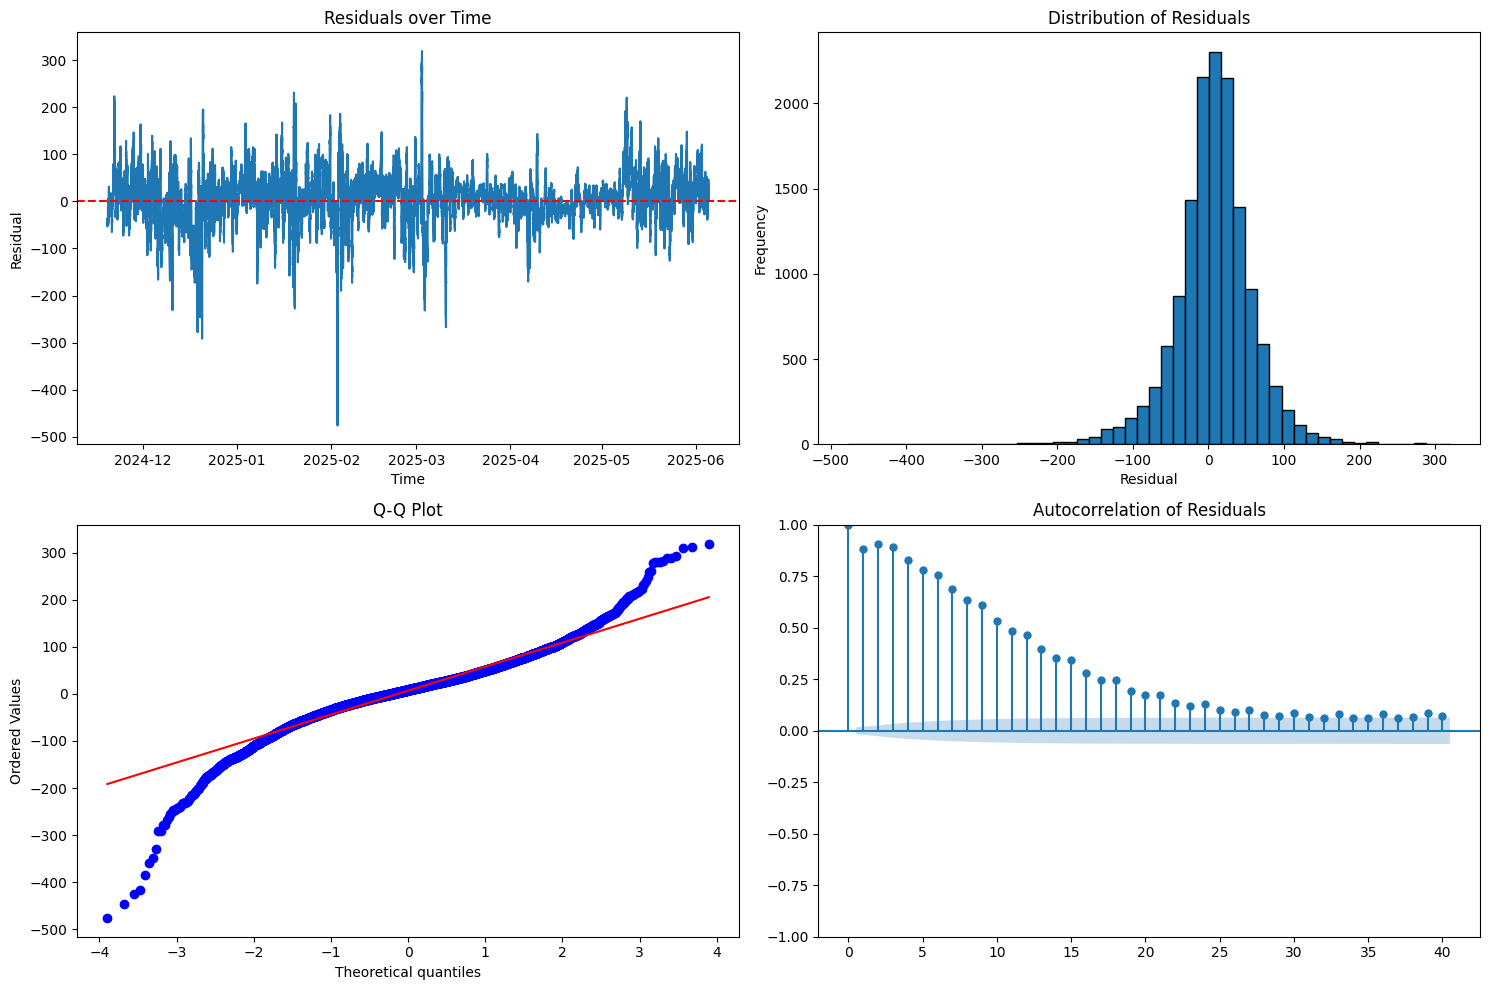

Backtesting: 100%|██████████| 4753/4753 [00:33<00:00, 140.02it/s]


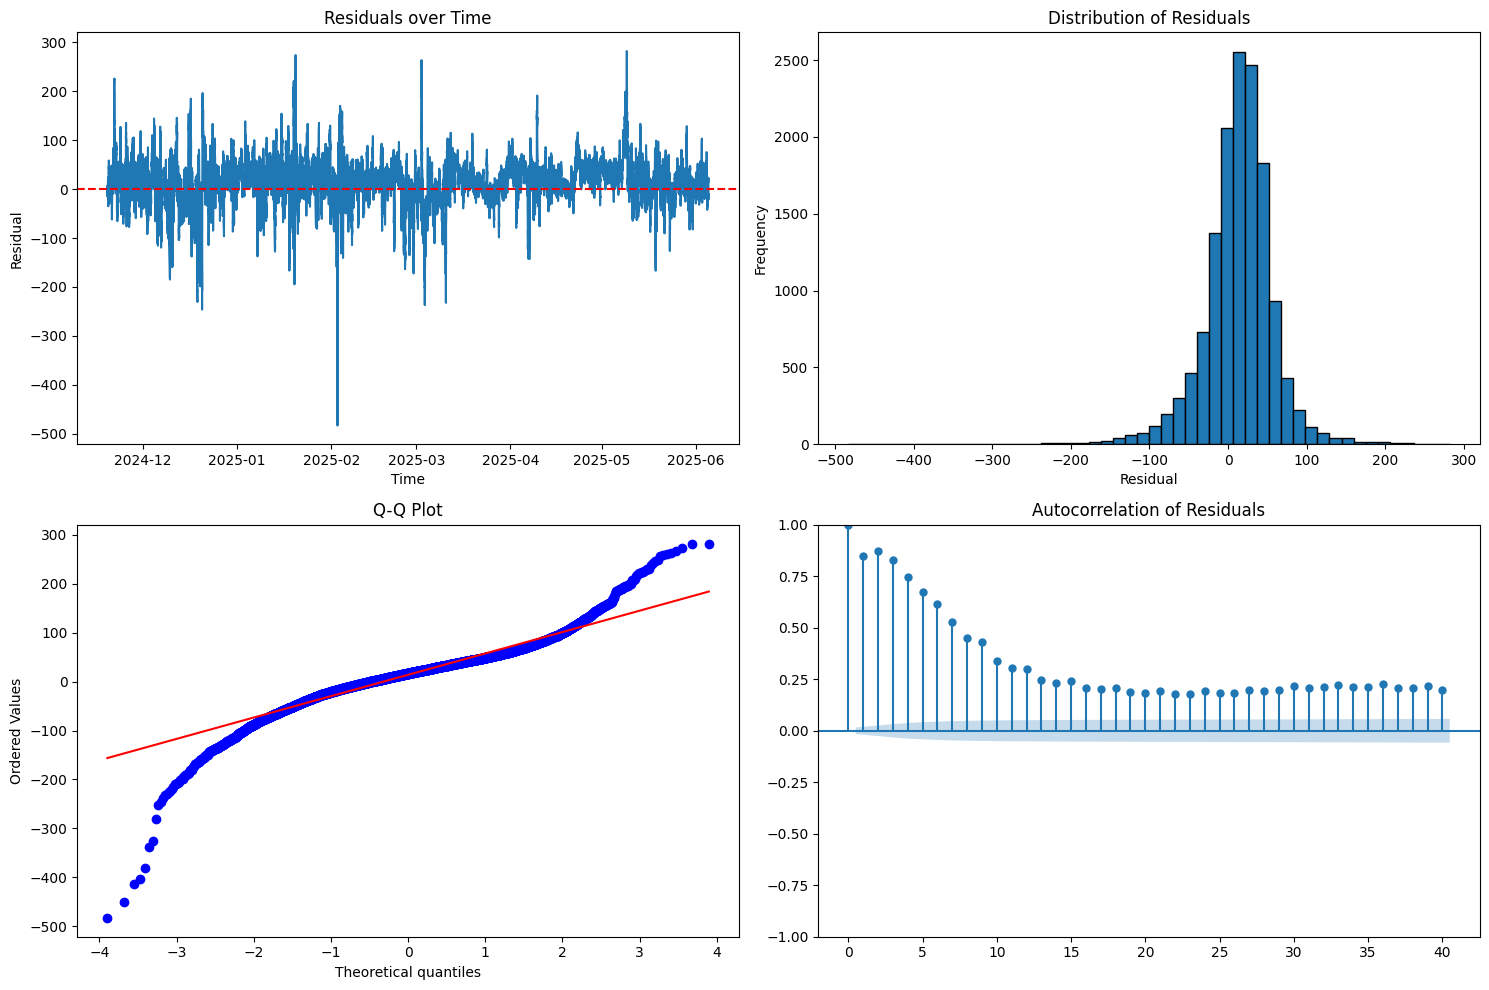


Model Comparison:
              mse       rmse        mae      mape        r2  \
LSTM  2778.553429  52.711986  37.829861  1.437183  0.994658   
GRU   2241.015314  47.339363  34.855909  1.382104  0.995691   

      directional_accuracy    rmse_h1     mae_h1    rmse_h2     mae_h2  \
LSTM              0.497195  47.416327  34.144025  53.261669  38.455988   
GRU               0.507785  43.745641  33.649228  46.617815  34.039422   

        rmse_h3     mae_h3  
LSTM  57.013567  40.889569  
GRU   51.343395  36.879076  


In [36]:
class Backtester:
    
    def __init__(self, model, scaler_X, scaler_y, sequence_length, prediction_horizon):
        self.model = model
        self.scaler_X = scaler_X
        self.scaler_y = scaler_y
        self.sequence_length = sequence_length
        self.prediction_horizon = prediction_horizon
        self.results = []
        
    def backtest(self, X, y, start_idx, end_idx, refit_frequency=None):
        predictions = []
        actuals = []
        timestamps = []
        
        for i in tqdm(range(start_idx, end_idx - self.prediction_horizon), desc="Backtesting"):
            X_seq = X.iloc[i - self.sequence_length:i]
            X_seq_scaled = self.scaler_X.transform(X_seq)
            X_tensor = torch.FloatTensor(X_seq_scaled).unsqueeze(0).cuda()
            
            self.model.eval()
            with torch.no_grad():
                pred_scaled = self.model(X_tensor).cpu().numpy()
            
            pred = self.scaler_y.inverse_transform(pred_scaled.reshape(-1, 1)).ravel()
            
            predictions.append(pred)
            actuals.append(y.iloc[i:i + self.prediction_horizon].values)
            timestamps.append(y.index[i:i + self.prediction_horizon])
            
            if refit_frequency and (i - start_idx) % refit_frequency == 0 and i > start_idx:
                print(f"Refitting model at step {i - start_idx}")
        
        return predictions, actuals, timestamps
    
    def calculate_metrics(self, predictions, actuals):
        
        predictions_flat = np.concatenate(predictions)
        actuals_flat = np.concatenate(actuals)
        
        metrics = {
            'mse': mean_squared_error(actuals_flat, predictions_flat),
            'rmse': np.sqrt(mean_squared_error(actuals_flat, predictions_flat)),
            'mae': mean_absolute_error(actuals_flat, predictions_flat),
            'mape': np.mean(np.abs((actuals_flat - predictions_flat) / actuals_flat)) * 100,
            'r2': r2_score(actuals_flat, predictions_flat),
            'directional_accuracy': np.mean(np.sign(np.diff(predictions_flat)) == np.sign(np.diff(actuals_flat)))
        }
        
        for h in range(self.prediction_horizon):
            h_predictions = [p[h] for p in predictions if len(p) > h]
            h_actuals = [a[h] for a in actuals if len(a) > h]
            
            metrics[f'rmse_h{h+1}'] = np.sqrt(mean_squared_error(h_actuals, h_predictions))
            metrics[f'mae_h{h+1}'] = mean_absolute_error(h_actuals, h_predictions)
        
        return metrics
    
    def plot_results(self, predictions, actuals, timestamps, model_name):
        predictions_flat = []
        actuals_flat = []
        timestamps_flat = []
        
        for i in range(len(predictions)):
            for h in range(len(predictions[i])):
                predictions_flat.append(predictions[i][h])
                actuals_flat.append(actuals[i][h])
                timestamps_flat.append(timestamps[i][h])
        
        fig = go.Figure()
        
        fig.add_trace(go.Scatter(
            x=timestamps_flat,
            y=actuals_flat,
            mode='lines',
            name='Actual',
            line=dict(color='blue', width=2)
        ))
        
        fig.add_trace(go.Scatter(
            x=timestamps_flat,
            y=predictions_flat,
            mode='lines',
            name='Predicted',
            line=dict(color='red', width=2, dash='dash')
        ))
        
        fig.update_layout(
            title=f'{model_name} Backtesting Results',
            xaxis_title='Time',
            yaxis_title='ETH Price (USDT)',
            hovermode='x unified'
        )
        
        fig.show()
        
        residuals = np.array(actuals_flat) - np.array(predictions_flat)
        
        fig, axes = plt.subplots(2, 2, figsize=(15, 10))
        
        axes[0, 0].plot(timestamps_flat, residuals)
        axes[0, 0].axhline(y=0, color='r', linestyle='--')
        axes[0, 0].set_title('Residuals over Time')
        axes[0, 0].set_xlabel('Time')
        axes[0, 0].set_ylabel('Residual')
        
        axes[0, 1].hist(residuals, bins=50, edgecolor='black')
        axes[0, 1].set_title('Distribution of Residuals')
        axes[0, 1].set_xlabel('Residual')
        axes[0, 1].set_ylabel('Frequency')
        
        from scipy import stats
        stats.probplot(residuals, dist="norm", plot=axes[1, 0])
        axes[1, 0].set_title('Q-Q Plot')
        
        from statsmodels.graphics.tsaplots import plot_acf
        plot_acf(residuals, lags=40, ax=axes[1, 1])
        axes[1, 1].set_title('Autocorrelation of Residuals')
        
        plt.tight_layout()
        plt.show()

test_start_idx = len(X_selected) - len(test_dataset) - sequence_length
test_end_idx = len(X_selected)

lstm_backtester = Backtester(lstm_model, scaler_X, scaler_y, sequence_length, prediction_horizon)
lstm_predictions, lstm_actuals, lstm_timestamps = lstm_backtester.backtest(
    X_selected, y, test_start_idx, test_end_idx
)
lstm_metrics = lstm_backtester.calculate_metrics(lstm_predictions, lstm_actuals)
lstm_backtester.plot_results(lstm_predictions, lstm_actuals, lstm_timestamps, "LSTM")

gru_backtester = Backtester(gru_model, scaler_X, scaler_y, sequence_length, prediction_horizon)
gru_predictions, gru_actuals, gru_timestamps = gru_backtester.backtest(
    X_selected, y, test_start_idx, test_end_idx
)
gru_metrics = gru_backtester.calculate_metrics(gru_predictions, gru_actuals)
gru_backtester.plot_results(gru_predictions, gru_actuals, gru_timestamps, "GRU")

comparison_df = pd.DataFrame({
    'LSTM': lstm_metrics,
    'GRU': gru_metrics
}).T

print("\nModel Comparison:")
print(comparison_df)

## **Forecasting 3h**

In [40]:
def forecast_future(model, X, y, scaler_X, scaler_y, sequence_length, prediction_horizon):
    last_sequence = X.iloc[-sequence_length:]
    last_sequence_scaled = scaler_X.transform(last_sequence)
    
    X_tensor = torch.FloatTensor(last_sequence_scaled).unsqueeze(0).cuda()
    
    model.eval()
    with torch.no_grad():
        forecast_scaled = model(X_tensor).cpu().numpy()
    
    forecast = scaler_y.inverse_transform(forecast_scaled.reshape(-1, 1)).ravel()
    
    last_timestamp = y.index[-1]
    forecast_timestamps = pd.date_range(start=last_timestamp + pd.Timedelta(hours=1), 
                                       periods=prediction_horizon, freq='h')
    
    return forecast, forecast_timestamps

lstm_forecast, forecast_timestamps = forecast_future(
    lstm_model, X_selected, y, scaler_X, scaler_y, sequence_length, prediction_horizon
)

gru_forecast, _ = forecast_future(
    gru_model, X_selected, y, scaler_X, scaler_y, sequence_length, prediction_horizon
)

fig = make_subplots(rows=3, cols=1, shared_xaxes=True, 
                    vertical_spacing=0.05,
                    subplot_titles=('ETH Price with Forecasts', 'RSI', 'MACD'),
                    row_heights=[0.6, 0.2, 0.2])

recent_data = df.iloc[-500:]  

fig.add_trace(go.Candlestick(x=recent_data.index,
                              open=recent_data['open_ETH_USDT'],
                              high=recent_data['high_ETH_USDT'],
                              low=recent_data['low_ETH_USDT'],
                              close=recent_data['close_ETH_USDT'],
                              name='ETH/USDT'), row=1, col=1)

fig.add_trace(go.Scatter(x=recent_data.index, y=recent_data['sma_14'],
                         mode='lines', name='SMA 14', line=dict(color='orange')), row=1, col=1)
fig.add_trace(go.Scatter(x=recent_data.index, y=recent_data['ema_14'],
                         mode='lines', name='EMA 14', line=dict(color='green')), row=1, col=1)

fig.add_trace(go.Scatter(x=recent_data.index, y=recent_data['bb_upper'],
                         mode='lines', name='BB Upper', line=dict(color='gray', dash='dash')), row=1, col=1)
fig.add_trace(go.Scatter(x=recent_data.index, y=recent_data['bb_lower'],
                         mode='lines', name='BB Lower', line=dict(color='gray', dash='dash')), row=1, col=1)

fig.add_trace(go.Scatter(x=forecast_timestamps, y=lstm_forecast,
                         mode='lines+markers', name='LSTM Forecast',
                         line=dict(color='red', width=3)), row=1, col=1)
fig.add_trace(go.Scatter(x=forecast_timestamps, y=gru_forecast,
                         mode='lines+markers', name='GRU Forecast',
                         line=dict(color='blue', width=3)), row=1, col=1)

fig.add_trace(go.Scatter(x=recent_data.index, y=recent_data['rsi_14'],
                         mode='lines', name='RSI', line=dict(color='purple')), row=2, col=1)
fig.add_hline(y=70, line_dash="dash", line_color="red", row=2, col=1)
fig.add_hline(y=30, line_dash="dash", line_color="green", row=2, col=1)

fig.add_trace(go.Scatter(x=recent_data.index, y=recent_data['macd'],
                         mode='lines', name='MACD', line=dict(color='blue')), row=3, col=1)
fig.add_trace(go.Scatter(x=recent_data.index, y=recent_data['macd_signal'],
                         mode='lines', name='Signal', line=dict(color='red')), row=3, col=1)

fig.update_layout(height=1000, title_text="Ethereum Price Analysis and Forecast",
                  showlegend=True, xaxis_rangeslider_visible=False)
fig.update_xaxes(title_text="Date", row=3, col=1)
fig.update_yaxes(title_text="Price (USDT)", row=1, col=1)
fig.update_yaxes(title_text="RSI", row=2, col=1)
fig.update_yaxes(title_text="MACD", row=3, col=1)

fig.show()

print("\nForecast Summary (Next 3 Hours):")
print("="*50)
for i, timestamp in enumerate(forecast_timestamps):
    print(f"{timestamp}: LSTM: ${lstm_forecast[i]:.2f}, GRU: ${gru_forecast[i]:.2f}")
print("="*50)
print(f"Average LSTM Forecast: ${np.mean(lstm_forecast):.2f}")
print(f"Average GRU Forecast: ${np.mean(gru_forecast):.2f}")


Forecast Summary (Next 3 Hours):
2025-06-05 10:00:00: LSTM: $2589.04, GRU: $2590.49
2025-06-05 11:00:00: LSTM: $2568.96, GRU: $2600.85
2025-06-05 12:00:00: LSTM: $2582.83, GRU: $2600.39
Average LSTM Forecast: $2580.28
Average GRU Forecast: $2597.24


## **Model Persistance**

In [41]:
def save_model_artifacts(model, scaler_X, scaler_y, selected_features, model_name):
    artifacts = {
        'model_state_dict': model.state_dict(),
        'model_config': {
            'input_size': len(selected_features),
            'hidden_size': model.hidden_size if hasattr(model, 'hidden_size') else None,
            'num_layers': model.num_layers if hasattr(model, 'num_layers') else None,
            'output_size': prediction_horizon,
            'sequence_length': sequence_length,
            'prediction_horizon': prediction_horizon
        },
        'scaler_X': scaler_X,
        'scaler_y': scaler_y,
        'selected_features': selected_features,
        'timestamp': datetime.now().strftime('%Y-%m-%d %H:%M:%S')
    }
    
    with open(f'{model_name}_artifacts.pkl', 'wb') as f:
        pickle.dump(artifacts, f)
    
    torch.save(model.state_dict(), f'{model_name}_model.pth')
    
    print(f"Model artifacts saved for {model_name}")

save_model_artifacts(lstm_model, scaler_X, scaler_y, selected_features, 'lstm')
save_model_artifacts(gru_model, scaler_X, scaler_y, selected_features, 'gru')

Model artifacts saved for lstm
Model artifacts saved for gru
